### Topic 1

Running naive baseline with actual prices using 5 consecutive validation weeks
Using train/test split from C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_ids.txt and C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\test_ids.txt
Loaded 6291 training listing IDs
Loaded 1573 test listing IDs
Loading data...
Data spans from 2023-08-07 to 2024-02-08
Total duration: 186 days (26 weeks)
Time-based CV folds with consecutive validation weeks:
Fold 1: Train 2023-08-07 to 2024-01-04, Validation 2024-01-05 to 2024-01-11
Fold 2: Train 2023-08-07 to 2024-01-11, Validation 2024-01-12 to 2024-01-18
Fold 3: Train 2023-08-07 to 2024-01-18, Validation 2024-01-19 to 2024-01-25
Fold 4: Train 2023-08-07 to 2024-01-25, Validation 2024-01-26 to 2024-02-01
Fold 5: Train 2023-08-07 to 2024-02-01, Validation 2024-02-02 to 2024-02-08

Processing fold 1 (Train: 2023-08-07 to 2024-01-04, Val: 2024-01-05 to 2024-01-11)...
Training data: 903142 rows, 6291 un

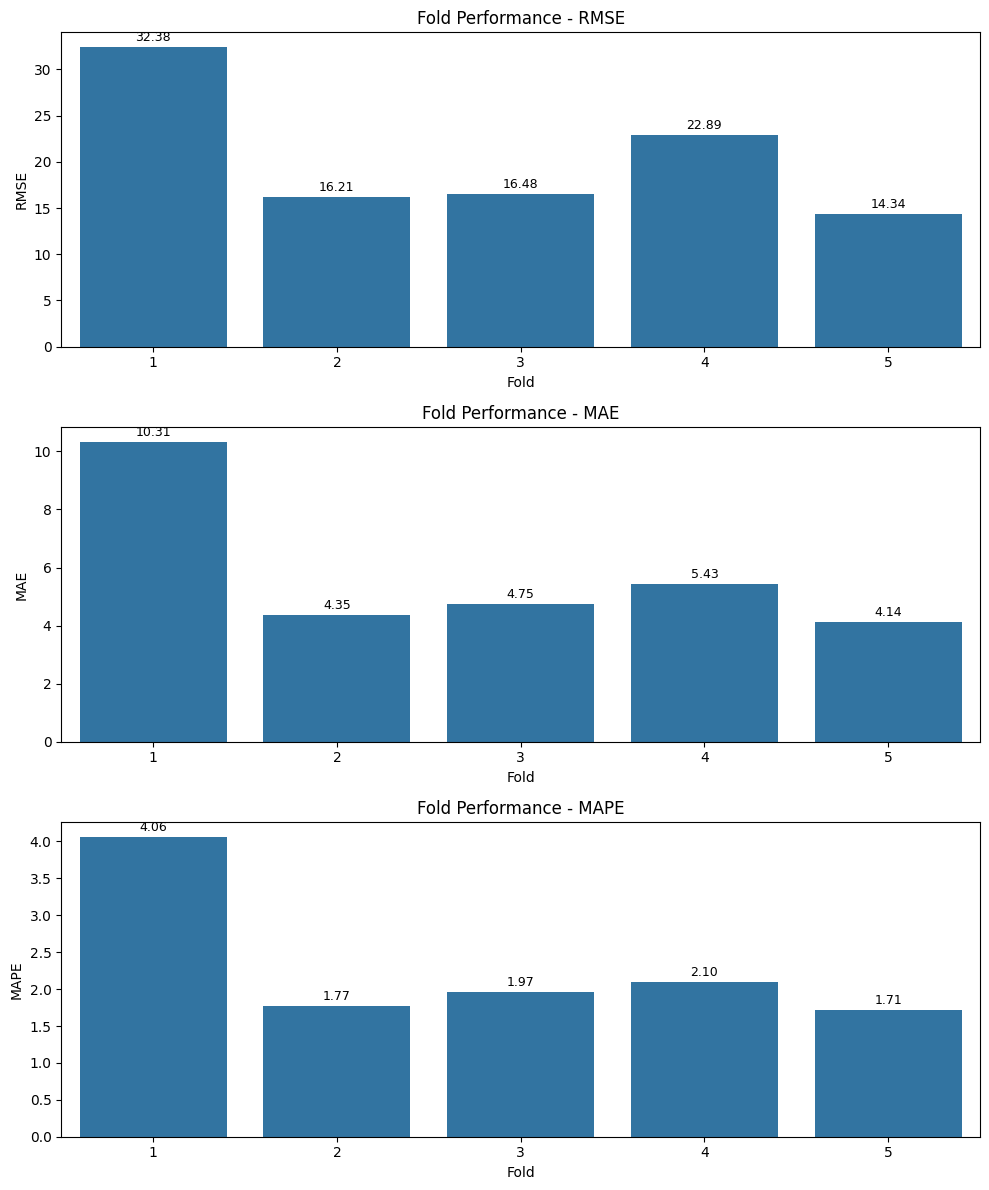

2. Time Series Metrics


C:\Users\mvk\AppData\Local\Temp\ipykernel_34224\1731541699.py:391: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', n_folds)


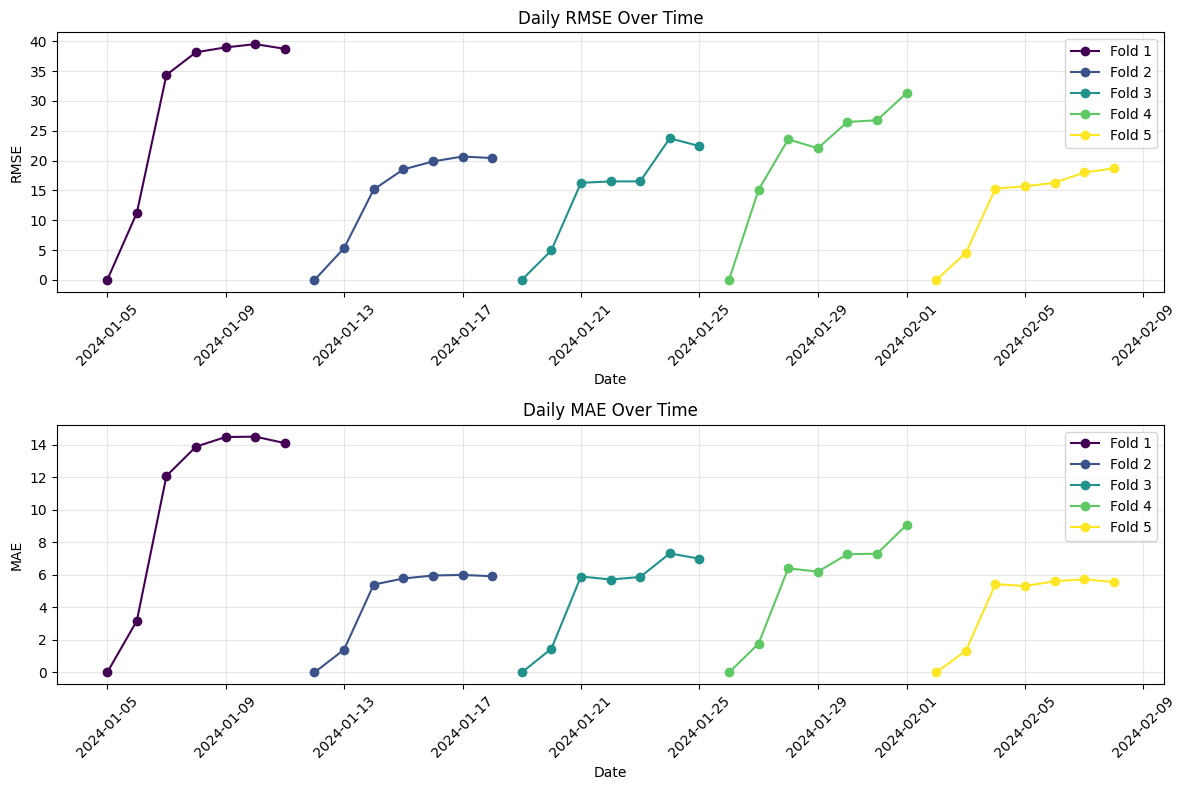

3. Feature Importance


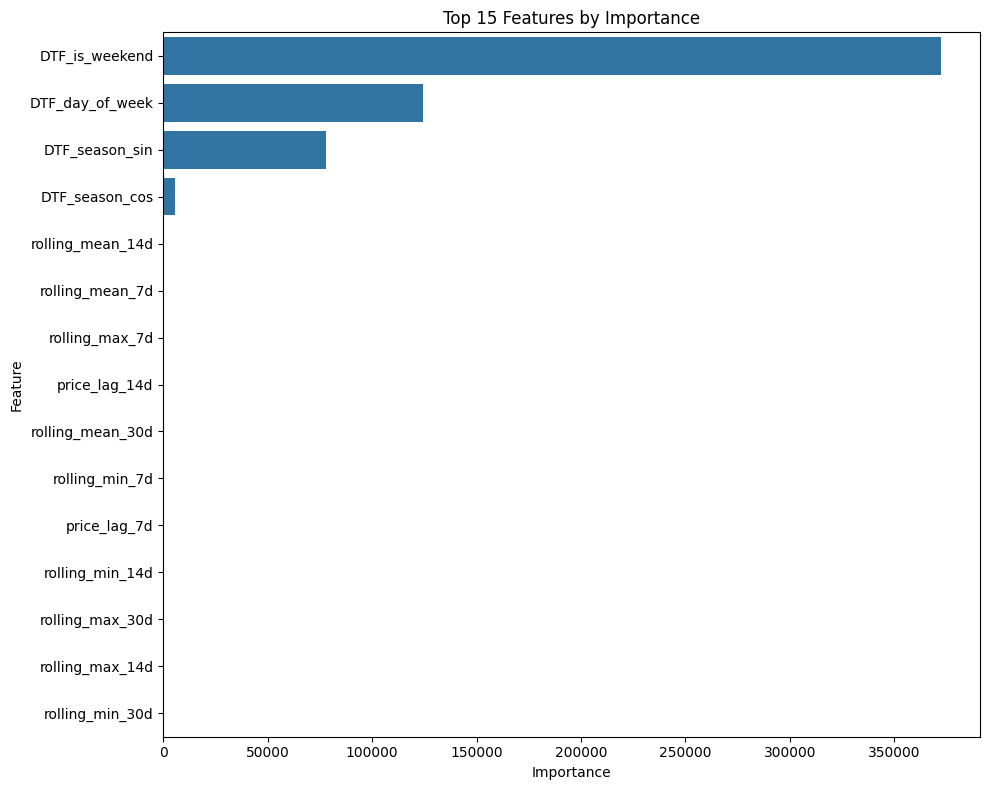

4. Error Analysis


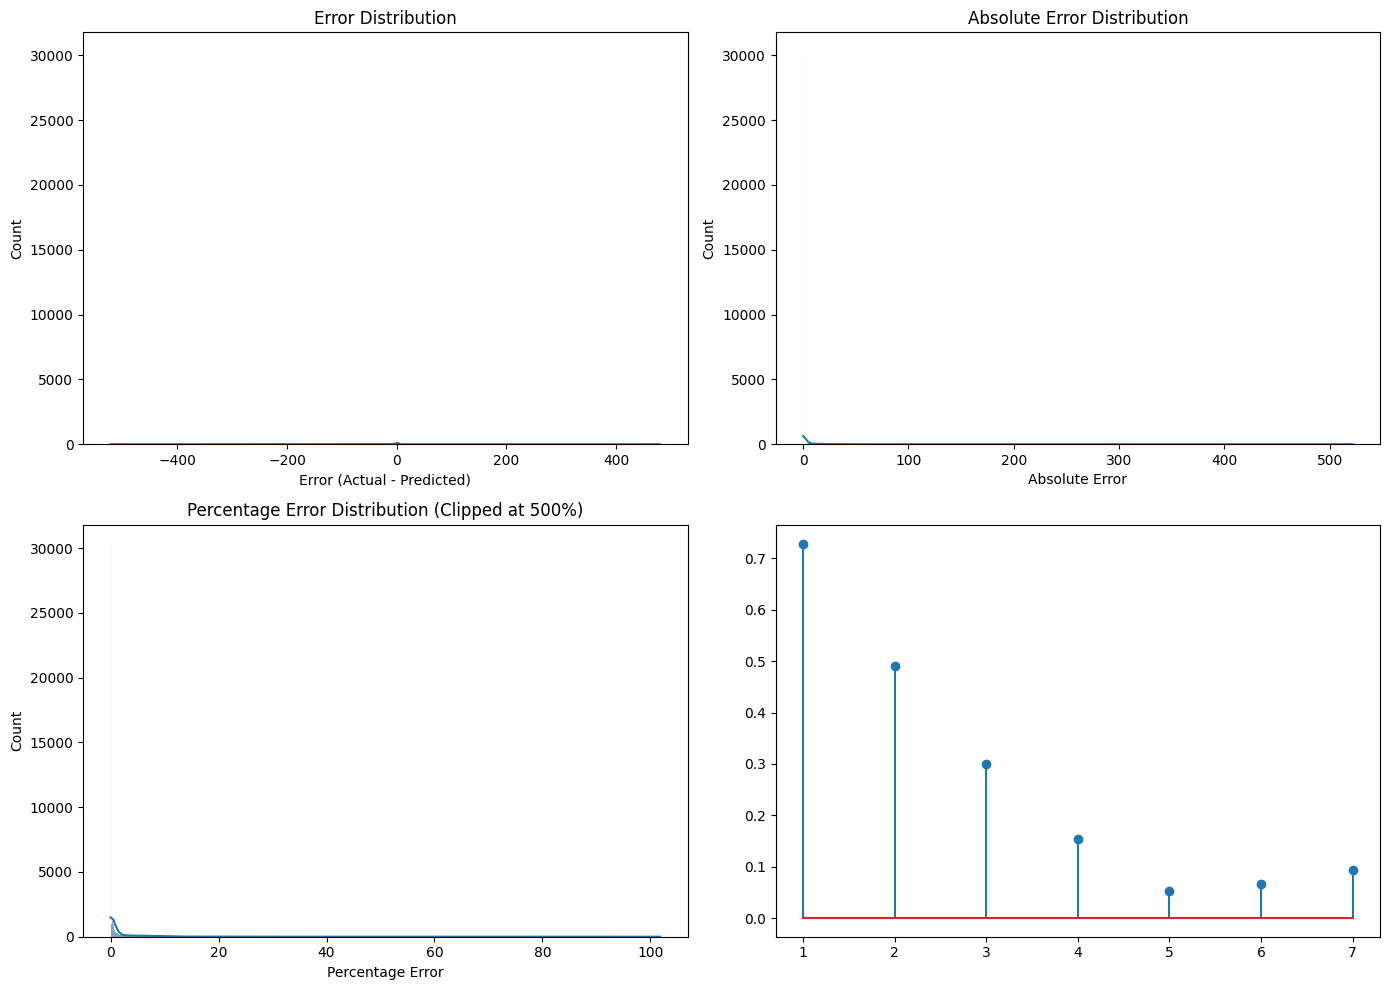

5. Actual vs Predicted Comparison


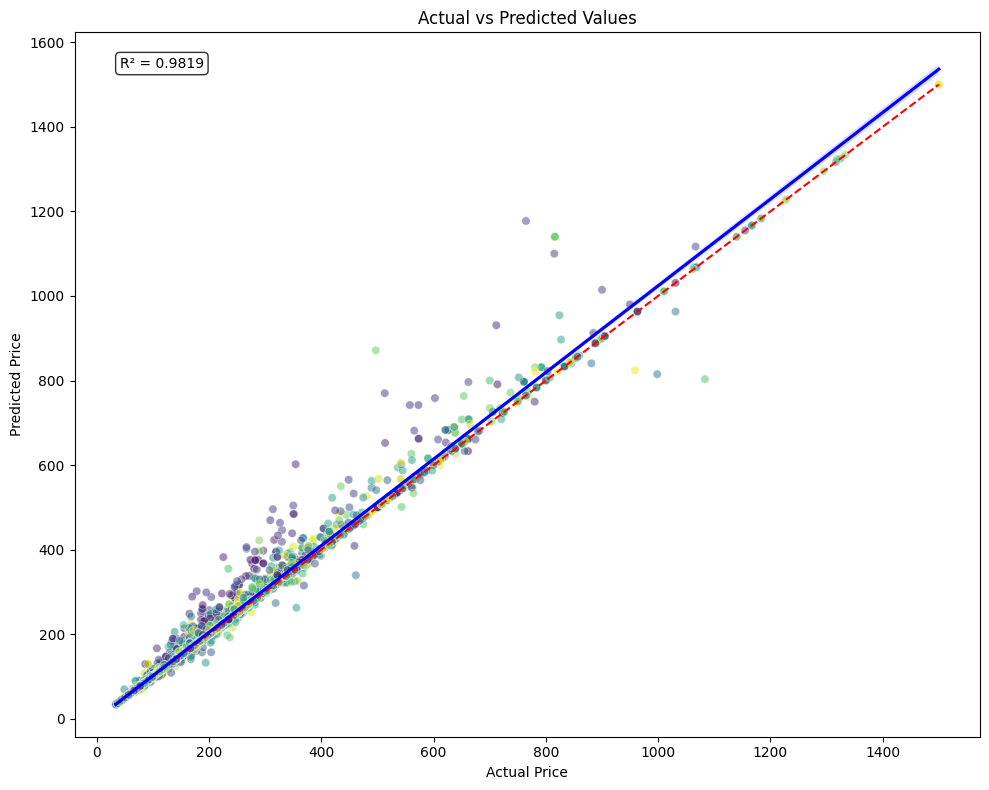

6. Sample Listing Comparisons


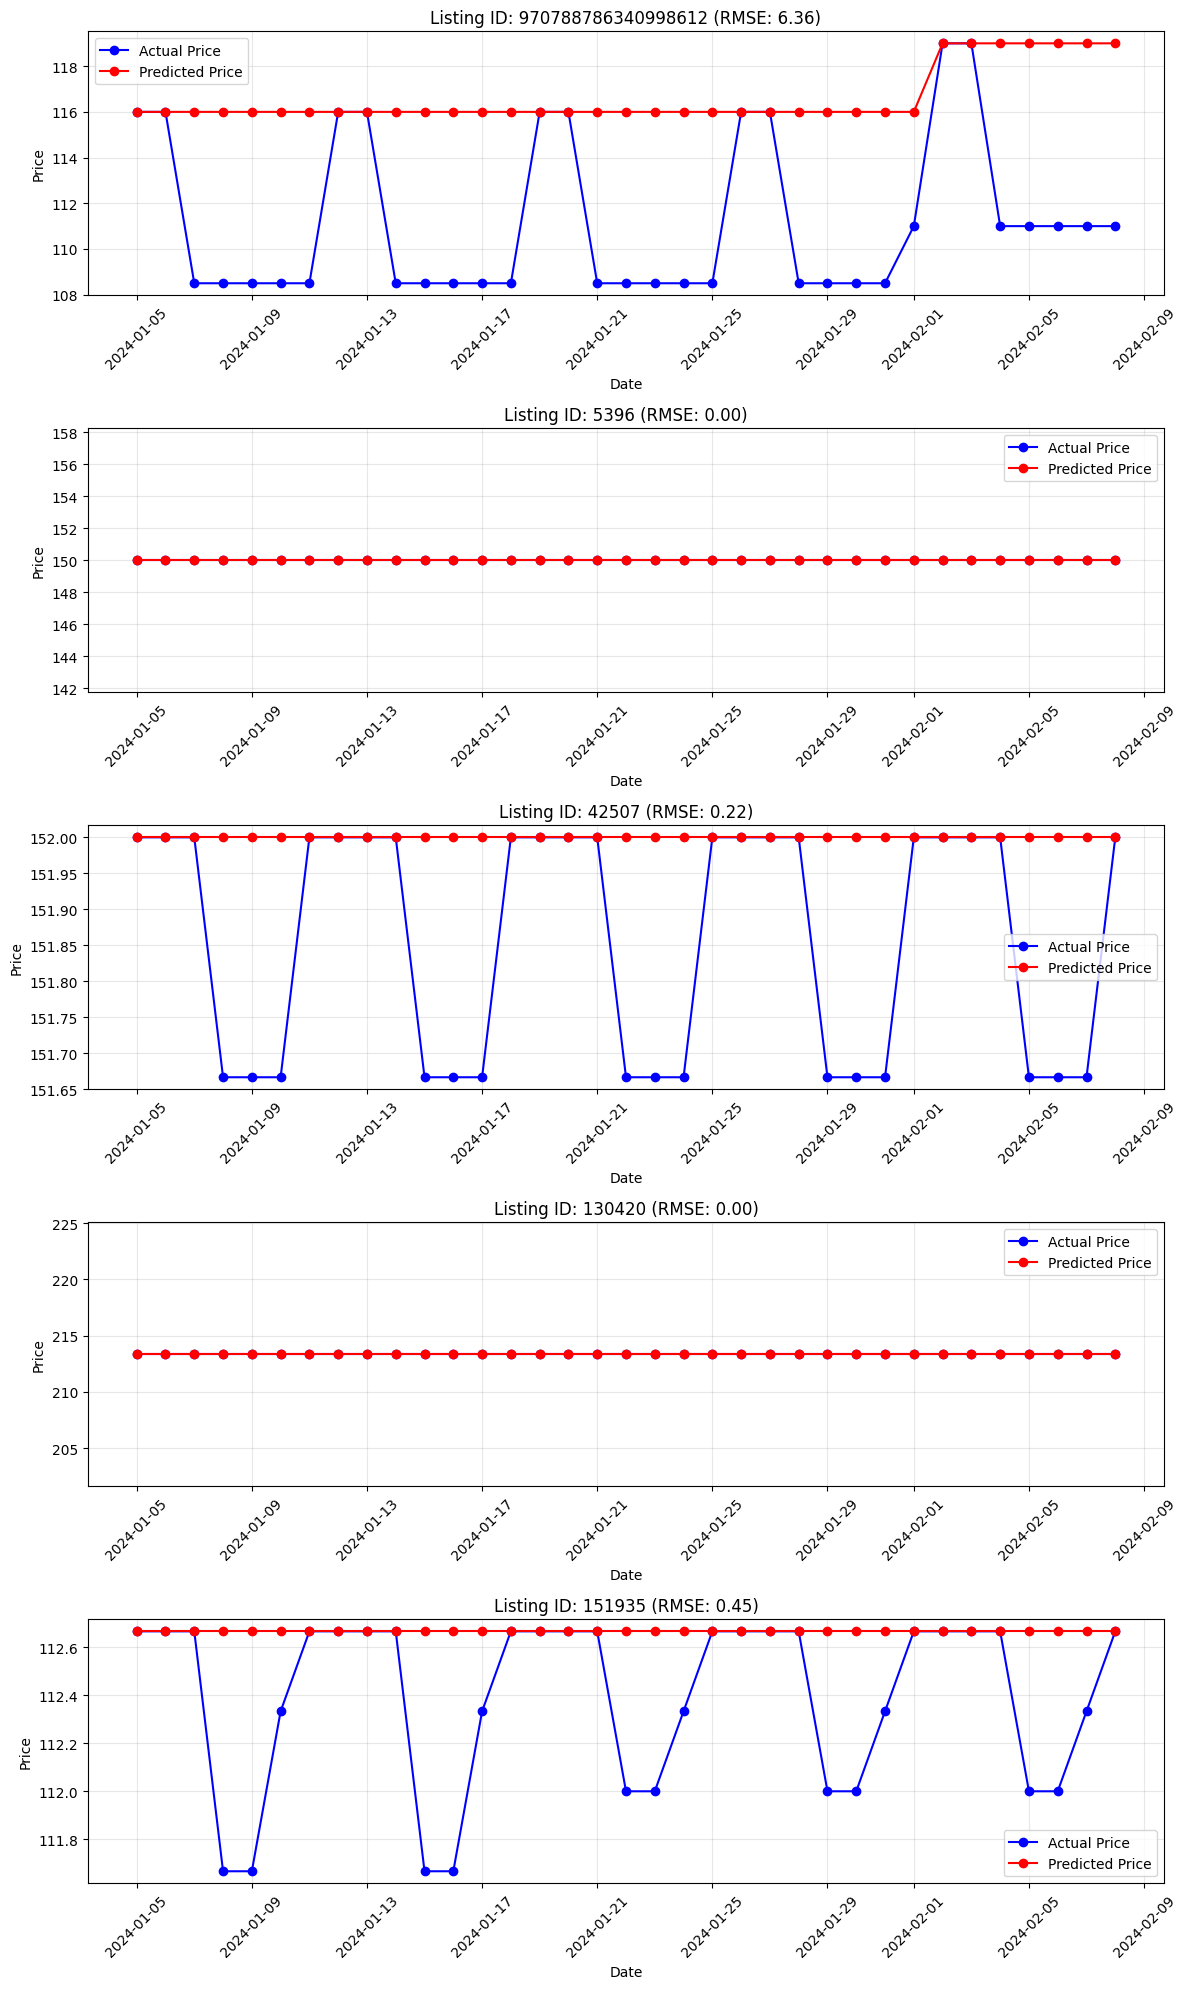


Comprehensive analysis complete.

Analysis complete.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import acf
import os
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

def run_naive_baseline_price_cv(data_path, train_ids_path, test_ids_path, n_folds=5, output_path=None):
    """
    Run naive baseline prediction using actual prices with time-based consecutive validation weeks.
    Each fold uses exactly 1 week for validation, with the validation weeks being the last n_folds weeks
    of the dataset in consecutive order.
    
    Parameters:
    data_path (str): Path to the CSV data file
    train_ids_path (str): Path to the train_ids.txt file
    test_ids_path (str): Path to the test_ids.txt file
    n_folds (int): Number of time-based CV folds (each fold uses 1 week for validation)
    output_path (str, optional): Path to save results CSV
    """
    print(f"Running naive baseline with actual prices using {n_folds} consecutive validation weeks")
    print(f"Using train/test split from {train_ids_path} and {test_ids_path}")
    
    # Load train and test IDs
    try:
        with open(train_ids_path, 'r') as f:
            train_ids = [int(line.strip()) for line in f.readlines()]
        print(f"Loaded {len(train_ids)} training listing IDs")
        
        with open(test_ids_path, 'r') as f:
            test_ids = [int(line.strip()) for line in f.readlines()]
        print(f"Loaded {len(test_ids)} test listing IDs")
    except Exception as e:
        raise ValueError(f"Error loading train/test IDs: {e}")
    
    # Load data
    print("Loading data...")
    data = pd.read_csv(data_path)
    
    # Convert date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    # Ensure we have the needed columns
    required_columns = ['listing_id', 'date', 'price']
    if not all(col in data.columns for col in required_columns):
        missing = [col for col in required_columns if col not in data.columns]
        raise ValueError(f"Missing required columns: {missing}")
    
    # Identify potential feature columns
    feature_cols = [col for col in data.columns 
                   if col not in ['listing_id', 'date', 'price', 
                                 'date_only', 'fold', 'previous_price', 
                                 'predicted_price', 'error', 'abs_error', 'pct_error']]
    
    # Sort by date
    data = data.sort_values(['listing_id', 'date'])
    
    # Get the min and max dates in the dataset
    min_date = data['date'].min()
    max_date = data['date'].max()
    
    print(f"Data spans from {min_date.date()} to {max_date.date()}")
    
    # Calculate total dataset duration
    total_days = (max_date - min_date).days + 1
    weeks_available = total_days // 7
    
    print(f"Total duration: {total_days} days ({weeks_available} weeks)")
    
    # Ensure we have enough weeks for validation
    if weeks_available < n_folds:
        raise ValueError(f"Not enough weeks in dataset for {n_folds} validation weeks. "
                         f"Need at least {n_folds} weeks, but have {weeks_available} weeks.")
    
    # Create consecutive time-based folds using the last n_folds weeks
    folds = []
    
    for i in range(n_folds):
        # Calculate weeks from the end (0 = last week, 1 = second last week, etc.)
        weeks_from_end = n_folds - 1 - i
        
        # Calculate validation start and end dates
        val_start = max_date - timedelta(days=(weeks_from_end + 1) * 7 - 1)
        val_end = max_date - timedelta(days=weeks_from_end * 7)
        
        # Ensure val_start is not before the first day of data
        if val_start < min_date:
            val_start = min_date
        
        # Training period ends just before validation
        train_end = val_start - timedelta(days=1)
        train_start = min_date
        
        folds.append({
            'fold': i + 1,
            'train_start': train_start,
            'train_end': train_end,
            'val_start': val_start,
            'val_end': val_end
        })
    
    print("Time-based CV folds with consecutive validation weeks:")
    for fold_info in folds:
        print(f"Fold {fold_info['fold']}: "
              f"Train {fold_info['train_start'].date()} to {fold_info['train_end'].date()}, "
              f"Validation {fold_info['val_start'].date()} to {fold_info['val_end'].date()}")
    
    # Initialize results storage
    fold_results = []
    feature_importance_results = []
    
    # Run cross-validation
    for fold_info in folds:
        fold = fold_info['fold']
        train_start = fold_info['train_start']
        train_end = fold_info['train_end']
        val_start = fold_info['val_start']
        val_end = fold_info['val_end']
        
        print(f"\nProcessing fold {fold} "
              f"(Train: {train_start.date()} to {train_end.date()}, "
              f"Val: {val_start.date()} to {val_end.date()})...")
        
        # Get training and validation data with listing ID filtering
        train_data = data[(data['date'] >= train_start) & 
                          (data['date'] <= train_end) & 
                          (data['listing_id'].isin(train_ids))].copy()
        
        val_data = data[(data['date'] >= val_start) & 
                        (data['date'] <= val_end) & 
                        (data['listing_id'].isin(test_ids))].copy()
        
        print(f"Training data: {len(train_data)} rows, {len(train_data['listing_id'].unique())} unique listings")
        print(f"Validation data: {len(val_data)} rows, {len(val_data['listing_id'].unique())} unique listings")
        
        # Check that we have data
        if len(val_data) == 0:
            print(f"Warning: No validation data for fold {fold}. Skipping.")
            continue
        
        # Sort validation data by listing_id and date
        val_data.sort_values(['listing_id', 'date'], inplace=True)
        
        # Predict method:
        # 1. For the first day of the validation week for each listing, use its price
        # 2. For subsequent days, use the prediction from the first day
        first_day_predictions = {}
        for listing_id, listing_data in val_data.groupby('listing_id'):
            first_day = listing_data['date'].min()
            first_day_row = listing_data[listing_data['date'] == first_day].iloc[0]
            first_day_predictions[listing_id] = first_day_row['price']
        
        # Create a prediction column
        val_data['predicted_price'] = val_data.apply(
            lambda row: first_day_predictions.get(row['listing_id'], row['price']),
            axis=1
        )
        
        # Calculate errors
        val_data['error'] = val_data['price'] - val_data['predicted_price']
        val_data['abs_error'] = np.abs(val_data['error'])
        val_data['pct_error'] = (np.abs(val_data['error']) / np.abs(val_data['price'] + 1e-8)) * 100
        
        # Add fold information
        val_data['fold'] = fold
        
        # Store results
        fold_results.append(val_data[['date', 'listing_id', 'price', 
                                     'predicted_price', 'error', 'abs_error', 'pct_error', 'fold']])
        
        # Feature importance analysis using a simple linear model
        if len(feature_cols) > 0:
            # Only include rows with valid features and target
            valid_features = val_data.dropna(subset=feature_cols + ['price', 'predicted_price'])
            
            if len(valid_features) > 0:
                try:
                    # Train a linear model to predict the error
                    X = valid_features[feature_cols]
                    y = valid_features['error']  # We're trying to predict the error of our naive model
                    
                    # Train model and get feature importances
                    model = LinearRegression()
                    model.fit(X, y)
                    
                    # Get feature importances
                    importances = np.abs(model.coef_)
                    importance_df = pd.DataFrame({
                        'feature': feature_cols,
                        'importance': importances,
                        'fold': fold
                    })
                    feature_importance_results.append(importance_df)
                    
                    # Also try permutation importance for more robust results
                    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
                    perm_importance_df = pd.DataFrame({
                        'feature': feature_cols,
                        'importance': perm_importance.importances_mean,
                        'fold': fold,
                        'method': 'permutation'
                    })
                    feature_importance_results.append(perm_importance_df)
                    
                except Exception as e:
                    print(f"Warning: Could not calculate feature importance for fold {fold}: {e}")
    
    # Combine all results
    if not fold_results:
        print("Warning: No results to process. Check if data and folds are valid.")
        return None
        
    all_results = pd.concat(fold_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price'].values
    y_pred = all_results['predicted_price'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
    }
    
    print("\nOverall Metrics:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R²: {metrics['r2']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    
    # Calculate metrics for each fold
    fold_metrics = []
    for fold in range(1, n_folds + 1):
        fold_data = all_results[all_results['fold'] == fold]
        
        if len(fold_data) == 0:
            continue
        
        y_true_fold = fold_data['price'].values
        y_pred_fold = fold_data['predicted_price'].values
        
        fold_metrics.append({
            'fold': fold,
            'start_date': fold_data['date'].min(),
            'end_date': fold_data['date'].max(),
            'rmse': np.sqrt(mean_squared_error(y_true_fold, y_pred_fold)),
            'mae': mean_absolute_error(y_true_fold, y_pred_fold),
            'r2': r2_score(y_true_fold, y_pred_fold) if len(set(y_true_fold)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_fold - y_pred_fold) / (np.abs(y_true_fold) + 1e-8))) * 100,
            'n_samples': len(y_true_fold)
        })
    
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    # Calculate daily metrics
    all_results['date_only'] = all_results['date'].dt.date
    daily_metrics = []
    
    for date in all_results['date_only'].unique():
        date_data = all_results[all_results['date_only'] == date]
        
        y_true_day = date_data['price'].values
        y_pred_day = date_data['predicted_price'].values
        
        daily_metrics.append({
            'date': date,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (np.abs(y_true_day) + 1e-8))) * 100,
            'n_samples': len(y_true_day),
            'fold': date_data['fold'].iloc[0]  # Assume all records for a day are in the same fold
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Process feature importance results
    if feature_importance_results:
        feature_importance_df = pd.concat(feature_importance_results, ignore_index=True)
        
        # Calculate average importance across folds
        avg_importance = feature_importance_df.groupby(['feature', 'method'] 
                                                     if 'method' in feature_importance_df.columns 
                                                     else 'feature')['importance'].mean().reset_index()
        avg_importance = avg_importance.sort_values('importance', ascending=False)
    else:
        avg_importance = pd.DataFrame(columns=['feature', 'importance'])
        feature_importance_df = pd.DataFrame(columns=['feature', 'importance', 'fold'])
    
    # Calculate error autocorrelation
    error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values, max_lag=7)
    
    # Calculate error stability metrics
    error_stability = calculate_error_stability(daily_metrics_df)

    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': metrics,
        'fold_metrics': fold_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'error_autocorrelation': error_autocorrelation,
        'error_stability': error_stability,
        'feature_importance': avg_importance,
        'feature_importance_by_fold': feature_importance_df
    }
    
    # Save results to CSV if output path is provided
    if output_path:
        # Make sure the directory exists
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Save results
        all_results.to_csv(output_path, index=False)
        print(f"Results saved to {output_path}")
        
        # Also save fold metrics
        metrics_path = output_path.replace('.csv', '_fold_metrics.csv')
        fold_metrics_df.to_csv(metrics_path, index=False)
        print(f"Fold metrics saved to {metrics_path}")
        
        # Also save daily metrics
        daily_metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(daily_metrics_path, index=False)
        print(f"Daily metrics saved to {daily_metrics_path}")
        
        # Save feature importance
        if len(feature_importance_df) > 0:
            feature_path = output_path.replace('.csv', '_feature_importance.csv')
            avg_importance.to_csv(feature_path, index=False)
            print(f"Feature importance saved to {feature_path}")
    
    return evaluation_results

def plot_fold_performance(results):
    """
    Plot performance metrics across different folds
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_price_cv
    """
    fold_metrics = results['fold_metrics']
    
    metrics_to_plot = ['rmse', 'mae', 'mape']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 4 * len(metrics_to_plot)))
    
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i] if len(metrics_to_plot) > 1 else axes
        sns.barplot(x='fold', y=metric, data=fold_metrics, ax=ax)
        ax.set_title(f'Fold Performance - {metric.upper()}')
        ax.set_xlabel('Fold')
        ax.set_ylabel(metric.upper())
        
        # Add value labels on top of each bar
        for j, bar in enumerate(ax.patches):
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + (fold_metrics[metric].max() * 0.01),
                f'{bar.get_height():.2f}',
                ha='center',
                va='bottom',
                fontsize=9
            )
    
    plt.tight_layout()
    plt.savefig('results/fold_performance.png')
    plt.show()

def plot_time_series_metrics(results):
    """
    Plot metrics over time
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_price_cv
    """
    daily_metrics = results['daily_metrics']
    daily_metrics['date'] = pd.to_datetime(daily_metrics['date'])
    daily_metrics = daily_metrics.sort_values('date')
    
    metrics_to_plot = ['rmse', 'mae']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 8))
    
    for i, metric in enumerate(metrics_to_plot):
        # Create colormap based on fold
        n_folds = len(daily_metrics['fold'].unique())
        cmap = plt.cm.get_cmap('viridis', n_folds)
        colors = [cmap(i) for i in range(n_folds)]
        
        for fold, fold_data in daily_metrics.groupby('fold'):
            axes[i].plot(
                fold_data['date'], 
                fold_data[metric], 
                marker='o', 
                linestyle='-', 
                label=f'Fold {fold}',
                color=colors[int(fold)-1]
            )
        
        axes[i].set_title(f'Daily {metric.upper()} Over Time')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(metric.upper())
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Format x-axis date ticks
        axes[i].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.savefig('results/time_series_metrics.png')
    plt.show()

def plot_feature_importance(results):
    """
    Plot feature importance
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_price_cv
    """
    # Check if we have feature importance data
    if 'feature_importance' not in results or len(results['feature_importance']) == 0:
        print("No feature importance data available.")
        return
    
    # Get top 15 features by importance
    feature_importance = results['feature_importance']
    
    # If 'method' column exists, get only the permutation importances
    if 'method' in feature_importance.columns:
        perm_importance = feature_importance[feature_importance['method'] == 'permutation']
        if len(perm_importance) > 0:
            feature_importance = perm_importance
    
    top_features = feature_importance.sort_values('importance', ascending=False).head(15)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=top_features)
    plt.title('Top 15 Features by Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig('results/feature_importance.png')
    plt.show()

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    error_acf = acf(errors, nlags=max_lag)
    return error_acf[1:]  # Exclude lag 0 (always 1)

def calculate_error_stability(daily_metrics_df):
    """Calculate error stability metrics"""
    mae_stability = daily_metrics_df['mae'].std() / daily_metrics_df['mae'].mean()
    return {
        'daily_mae': daily_metrics_df['mae'],
        'mae_stability_coefficient': mae_stability
    }

def plot_error_analysis(results):
    """
    Plot error distribution and autocorrelation with improved robustness
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_price_cv
    """
    all_results = results['all_results']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Error Distribution')
    axes[0, 0].set_xlabel('Error (Actual - Predicted)')
    
    # Absolute error distribution
    sns.histplot(all_results['abs_error'], kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Absolute Error Distribution')
    axes[0, 1].set_xlabel('Absolute Error')
    
    # Percentage error distribution
    # Clip extremely large percentage errors for better visualization
    pct_error_clipped = all_results['pct_error'].clip(upper=500)  # Clip at 500%
    sns.histplot(pct_error_clipped, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Percentage Error Distribution (Clipped at 500%)')
    axes[1, 0].set_xlabel('Percentage Error')
    
    # Error autocorrelation
    # Use the more robust autocorrelation calculation
    error_autocorr = calculate_error_autocorrelation(all_results['error'].values, max_lag=7)
    
    # In plot_error_analysis:
    if error_autocorr is not None:
        lags = np.arange(1, len(error_autocorr) + 1)  # Start from lag 1
        axes[1, 1].stem(lags, error_autocorr)
        
    plt.tight_layout()
    plt.savefig('results/error_analysis.png')
    plt.show()

def plot_actual_vs_predicted(results):
    """
    Plot actual vs predicted values
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_price_cv
    """
    all_results = results['all_results']
    
    # Scatter plot with regression line
    plt.figure(figsize=(10, 8))
    
    # Sample 5000 points if there are too many
    if len(all_results) > 5000:
        sample = all_results.sample(5000, random_state=42)
    else:
        sample = all_results
    
    # Create scatterplot with density coloring
    sns.scatterplot(
        x='price', 
        y='predicted_price', 
        data=sample, 
        alpha=0.5,
        hue=sample.index,  # A trick to color by density
        palette='viridis',
        legend=False
    )
    
    # Add perfect prediction line
    min_val = min(sample['price'].min(), sample['predicted_price'].min())
    max_val = max(sample['price'].max(), sample['predicted_price'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # Add regression line
    sns.regplot(
        x='price', 
        y='predicted_price', 
        data=sample,
        scatter=False, 
        line_kws={"color": "blue"}
    )
    
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    
    # Add R² value
    r2 = results['overall_metrics']['r2']
    plt.annotate(f'R² = {r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('results/actual_vs_predicted.png')
    plt.show()

def plot_comparison_by_listing(results, num_listings=5):
    """
    Plot comparison of actual vs predicted prices for selected listings
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_price_cv
    num_listings (int): Number of example listings to plot
    """
    all_results = results['all_results']
    
    # Select listings with the most data points
    listing_counts = all_results['listing_id'].value_counts().head(num_listings)
    selected_listings = listing_counts.index.tolist()
    
    # Plot actual vs predicted for each selected listing
    fig, axes = plt.subplots(num_listings, 1, figsize=(12, 4 * num_listings))
    
    for i, listing_id in enumerate(selected_listings):
        listing_data = all_results[all_results['listing_id'] == listing_id].sort_values('date')
        
        ax = axes[i] if num_listings > 1 else axes
        ax.plot(listing_data['date'], listing_data['price'], 'b-o', label='Actual Price')
        ax.plot(listing_data['date'], listing_data['predicted_price'], 'r-o', label='Predicted Price')
        
        # Calculate RMSE for this listing
        rmse = np.sqrt(mean_squared_error(listing_data['price'], listing_data['predicted_price']))
        
        ax.set_title(f'Listing ID: {listing_id} (RMSE: {rmse:.2f})')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Format x-axis date ticks
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.savefig('results/listing_comparisons.png')
    plt.show()

def print_summary(results):
    """
    Print a summary of the results
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_price_cv
    """
    print("\nSUMMARY OF NAIVE BASELINE PERFORMANCE:")
    print("=====================================")
    
    # Overall metrics
    overall = results['overall_metrics']
    print(f"Overall RMSE: {overall['rmse']:.4f}")
    print(f"Overall MAE: {overall['mae']:.4f}")
    print(f"Overall R²: {overall['r2']:.4f}")
    print(f"Overall MAPE: {overall['mape']:.2f}%")
    
    # Fold metrics
    print("\nPerformance by Fold:")
    print(results['fold_metrics'][['fold', 'rmse', 'mae', 'r2', 'mape', 'n_samples']])
    
    # Error stability
    # In print_summary function
    print("\n=== Error Autocorrelation ===")
    if results['error_autocorrelation'] is not None:
        # Get the original autocorrelation array (includes lag 0)
        autocorr = np.concatenate(([1.0], results['error_autocorrelation']))
        for i in range(1, len(autocorr)):
            print(f"Lag {i}: {autocorr[i]:.4f}")
    else:
        print("Autocorrelation not available")

    print("\n=== Error Stability ===")
    stability = results['error_stability']
    print(f"MAE stability coefficient: {stability['mae_stability_coefficient']:.4f}")
        
    # Sample size
    all_results = results['all_results']
    print(f"\nTotal Observations: {len(all_results)}")
    print(f"Unique Listings: {all_results['listing_id'].nunique()}")
    print(f"Date Range: {all_results['date'].min().date()} to {all_results['date'].max().date()}")
    
    # Top features if available
    if 'feature_importance' in results and len(results['feature_importance']) > 0:
        print("\nTop 5 Important Features:")
        top_features = results['feature_importance'].sort_values('importance', ascending=False).head(5)
        for _, row in top_features.iterrows():
            print(f"  - {row['feature']}: {row['importance']:.4f}")

def run_comprehensive_analysis(data_path, train_ids_path, test_ids_path, n_folds=5, output_path=None):
    """
    Run a comprehensive analysis of the naive baseline model with actual prices.
    Uses train/test split defined in text files.
    
    Parameters:
    data_path (str): Path to the data file
    train_ids_path (str): Path to the train_ids.txt file
    test_ids_path (str): Path to the test_ids.txt file
    n_folds (int): Number of time-based CV folds (each using 1 week for validation)
    output_path (str, optional): Path to save results
    """
    # Create results directory if it doesn't exist
    os.makedirs('results', exist_ok=True)
    
    # Run the cross-validation
    results = run_naive_baseline_price_cv(
        data_path=data_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        n_folds=n_folds,
        output_path=output_path
    )
    
    if results is None:
        print("Analysis failed. Check error messages above.")
        return None
    
    # Print summary
    print_summary(results)
    
    # Plot results
    print("\nGenerating visualizations...")
    
    print("1. Fold Performance Metrics")
    plot_fold_performance(results)
    
    print("2. Time Series Metrics")
    plot_time_series_metrics(results)
    
    print("3. Feature Importance")
    plot_feature_importance(results)
    
    print("4. Error Analysis")
    plot_error_analysis(results)
    
    def plot_error_analysis(results):

        all_results = results['all_results']
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Error distribution
        sns.histplot(all_results['error'], kde=True, ax=axes[0, 0])
        axes[0, 0].set_title('Error Distribution')
        axes[0, 0].set_xlabel('Error (Actual - Predicted)')
        
        # Absolute error distribution
        sns.histplot(all_results['abs_error'], kde=True, ax=axes[0, 1])
        axes[0, 1].set_title('Absolute Error Distribution')
        axes[0, 1].set_xlabel('Absolute Error')
        
        # Percentage error distribution
        sns.histplot(all_results['pct_error'], kde=True, ax=axes[1, 0])
        axes[1, 0].set_title('Percentage Error Distribution')
        axes[1, 0].set_xlabel('Percentage Error')
        
        # Error autocorrelation
        if results['error_autocorrelation'] is not None:
            lags = np.arange(len(results['error_autocorrelation']))
            axes[1, 1].stem(lags, results['error_autocorrelation'])
            axes[1, 1].set_title('Error Autocorrelation')
            axes[1, 1].set_xlabel('Lag')
            axes[1, 1].set_ylabel('Autocorrelation')
            # Add confidence bands
            n = len(all_results['error'])
            conf_level = 1.96 / np.sqrt(n)
            axes[1, 1].axhline(y=conf_level, linestyle='--', color='r')
            axes[1, 1].axhline(y=-conf_level, linestyle='--', color='r')
        else:
            axes[1, 1].text(0.5, 0.5, 'Autocorrelation not available', 
                            horizontalalignment='center', verticalalignment='center')
        
        plt.tight_layout()
        plt.savefig('results/error_analysis.png')
        plt.show()

def plot_actual_vs_predicted(results):
    """
    Plot actual vs predicted values
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_price_cv
    """
    all_results = results['all_results']
    
    # Scatter plot with regression line
    plt.figure(figsize=(10, 8))
    
    # Sample 5000 points if there are too many
    if len(all_results) > 5000:
        sample = all_results.sample(5000, random_state=42)
    else:
        sample = all_results
    
    # Create scatterplot with density coloring
    sns.scatterplot(
        x='price', 
        y='predicted_price', 
        data=sample, 
        alpha=0.5,
        hue=sample.index,  # A trick to color by density
        palette='viridis',
        legend=False
    )
    
    # Add perfect prediction line
    min_val = min(sample['price'].min(), sample['predicted_price'].min())
    max_val = max(sample['price'].max(), sample['predicted_price'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # Add regression line
    sns.regplot(
        x='price', 
        y='predicted_price', 
        data=sample,
        scatter=False, 
        line_kws={"color": "blue"}
    )
    
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    
    # Add R² value
    r2 = results['overall_metrics']['r2']
    plt.annotate(f'R² = {r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('results/actual_vs_predicted.png')
    plt.show()

def plot_comparison_by_listing(results, num_listings=5):
    """
    Plot comparison of actual vs predicted prices for selected listings
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_price_cv
    num_listings (int): Number of example listings to plot
    """
    all_results = results['all_results']
    
    # Select listings with the most data points
    listing_counts = all_results['listing_id'].value_counts().head(num_listings)
    selected_listings = listing_counts.index.tolist()
    
    # Plot actual vs predicted for each selected listing
    fig, axes = plt.subplots(num_listings, 1, figsize=(12, 4 * num_listings))
    
    for i, listing_id in enumerate(selected_listings):
        listing_data = all_results[all_results['listing_id'] == listing_id].sort_values('date')
        
        ax = axes[i] if num_listings > 1 else axes
        ax.plot(listing_data['date'], listing_data['price'], 'b-o', label='Actual Price')
        ax.plot(listing_data['date'], listing_data['predicted_price'], 'r-o', label='Predicted Price')
        
        # Calculate RMSE for this listing
        rmse = np.sqrt(mean_squared_error(listing_data['price'], listing_data['predicted_price']))
        
        ax.set_title(f'Listing ID: {listing_id} (RMSE: {rmse:.2f})')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Format x-axis date ticks
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.savefig('results/listing_comparisons.png')
    plt.show()

def run_comprehensive_analysis(data_path, train_ids_path, test_ids_path, n_folds=5, output_path=None):
    """
    Run a comprehensive analysis of the naive baseline model with actual prices.
    Uses train/test split defined in text files.
    
    Parameters:
    data_path (str): Path to the data file
    train_ids_path (str): Path to the train_ids.txt file
    test_ids_path (str): Path to the test_ids.txt file
    n_folds (int): Number of time-based CV folds (each using 1 week for validation)
    output_path (str, optional): Path to save results
    """
    # Create results directory if it doesn't exist
    os.makedirs('results', exist_ok=True)
    
    # Run the cross-validation
    results = run_naive_baseline_price_cv(
        data_path=data_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        n_folds=n_folds,
        output_path=output_path
    )
    
    if results is None:
        print("Analysis failed. Check error messages above.")
        return None
    
    # Print summary
    print_summary(results)
    
    # Plot results
    print("\nGenerating visualizations...")
    
    print("1. Fold Performance Metrics")
    plot_fold_performance(results)
    
    print("2. Time Series Metrics")
    plot_time_series_metrics(results)
    
    print("3. Feature Importance")
    plot_feature_importance(results)
    
    print("4. Error Analysis")
    plot_error_analysis(results)
    
    print("5. Actual vs Predicted Comparison")
    plot_actual_vs_predicted(results)
    
    print("6. Sample Listing Comparisons")
    plot_comparison_by_listing(results)
    
    print("\nComprehensive analysis complete.")
    
    return results

# Main execution
if __name__ == "__main__":
    # Specify path to your data and train/test IDs
    data_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_up3.csv"
    train_ids_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_ids.txt"
    test_ids_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\test_ids.txt"

    # Run comprehensive analysis with time-based CV using consecutive weeks
    results = run_comprehensive_analysis(
        data_path=data_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        n_folds=5,  # Will use the last 5 weeks as validation periods
        output_path="results/naive_baseline_price_cv_results.csv"
    )
    
    print("\nAnalysis complete.")

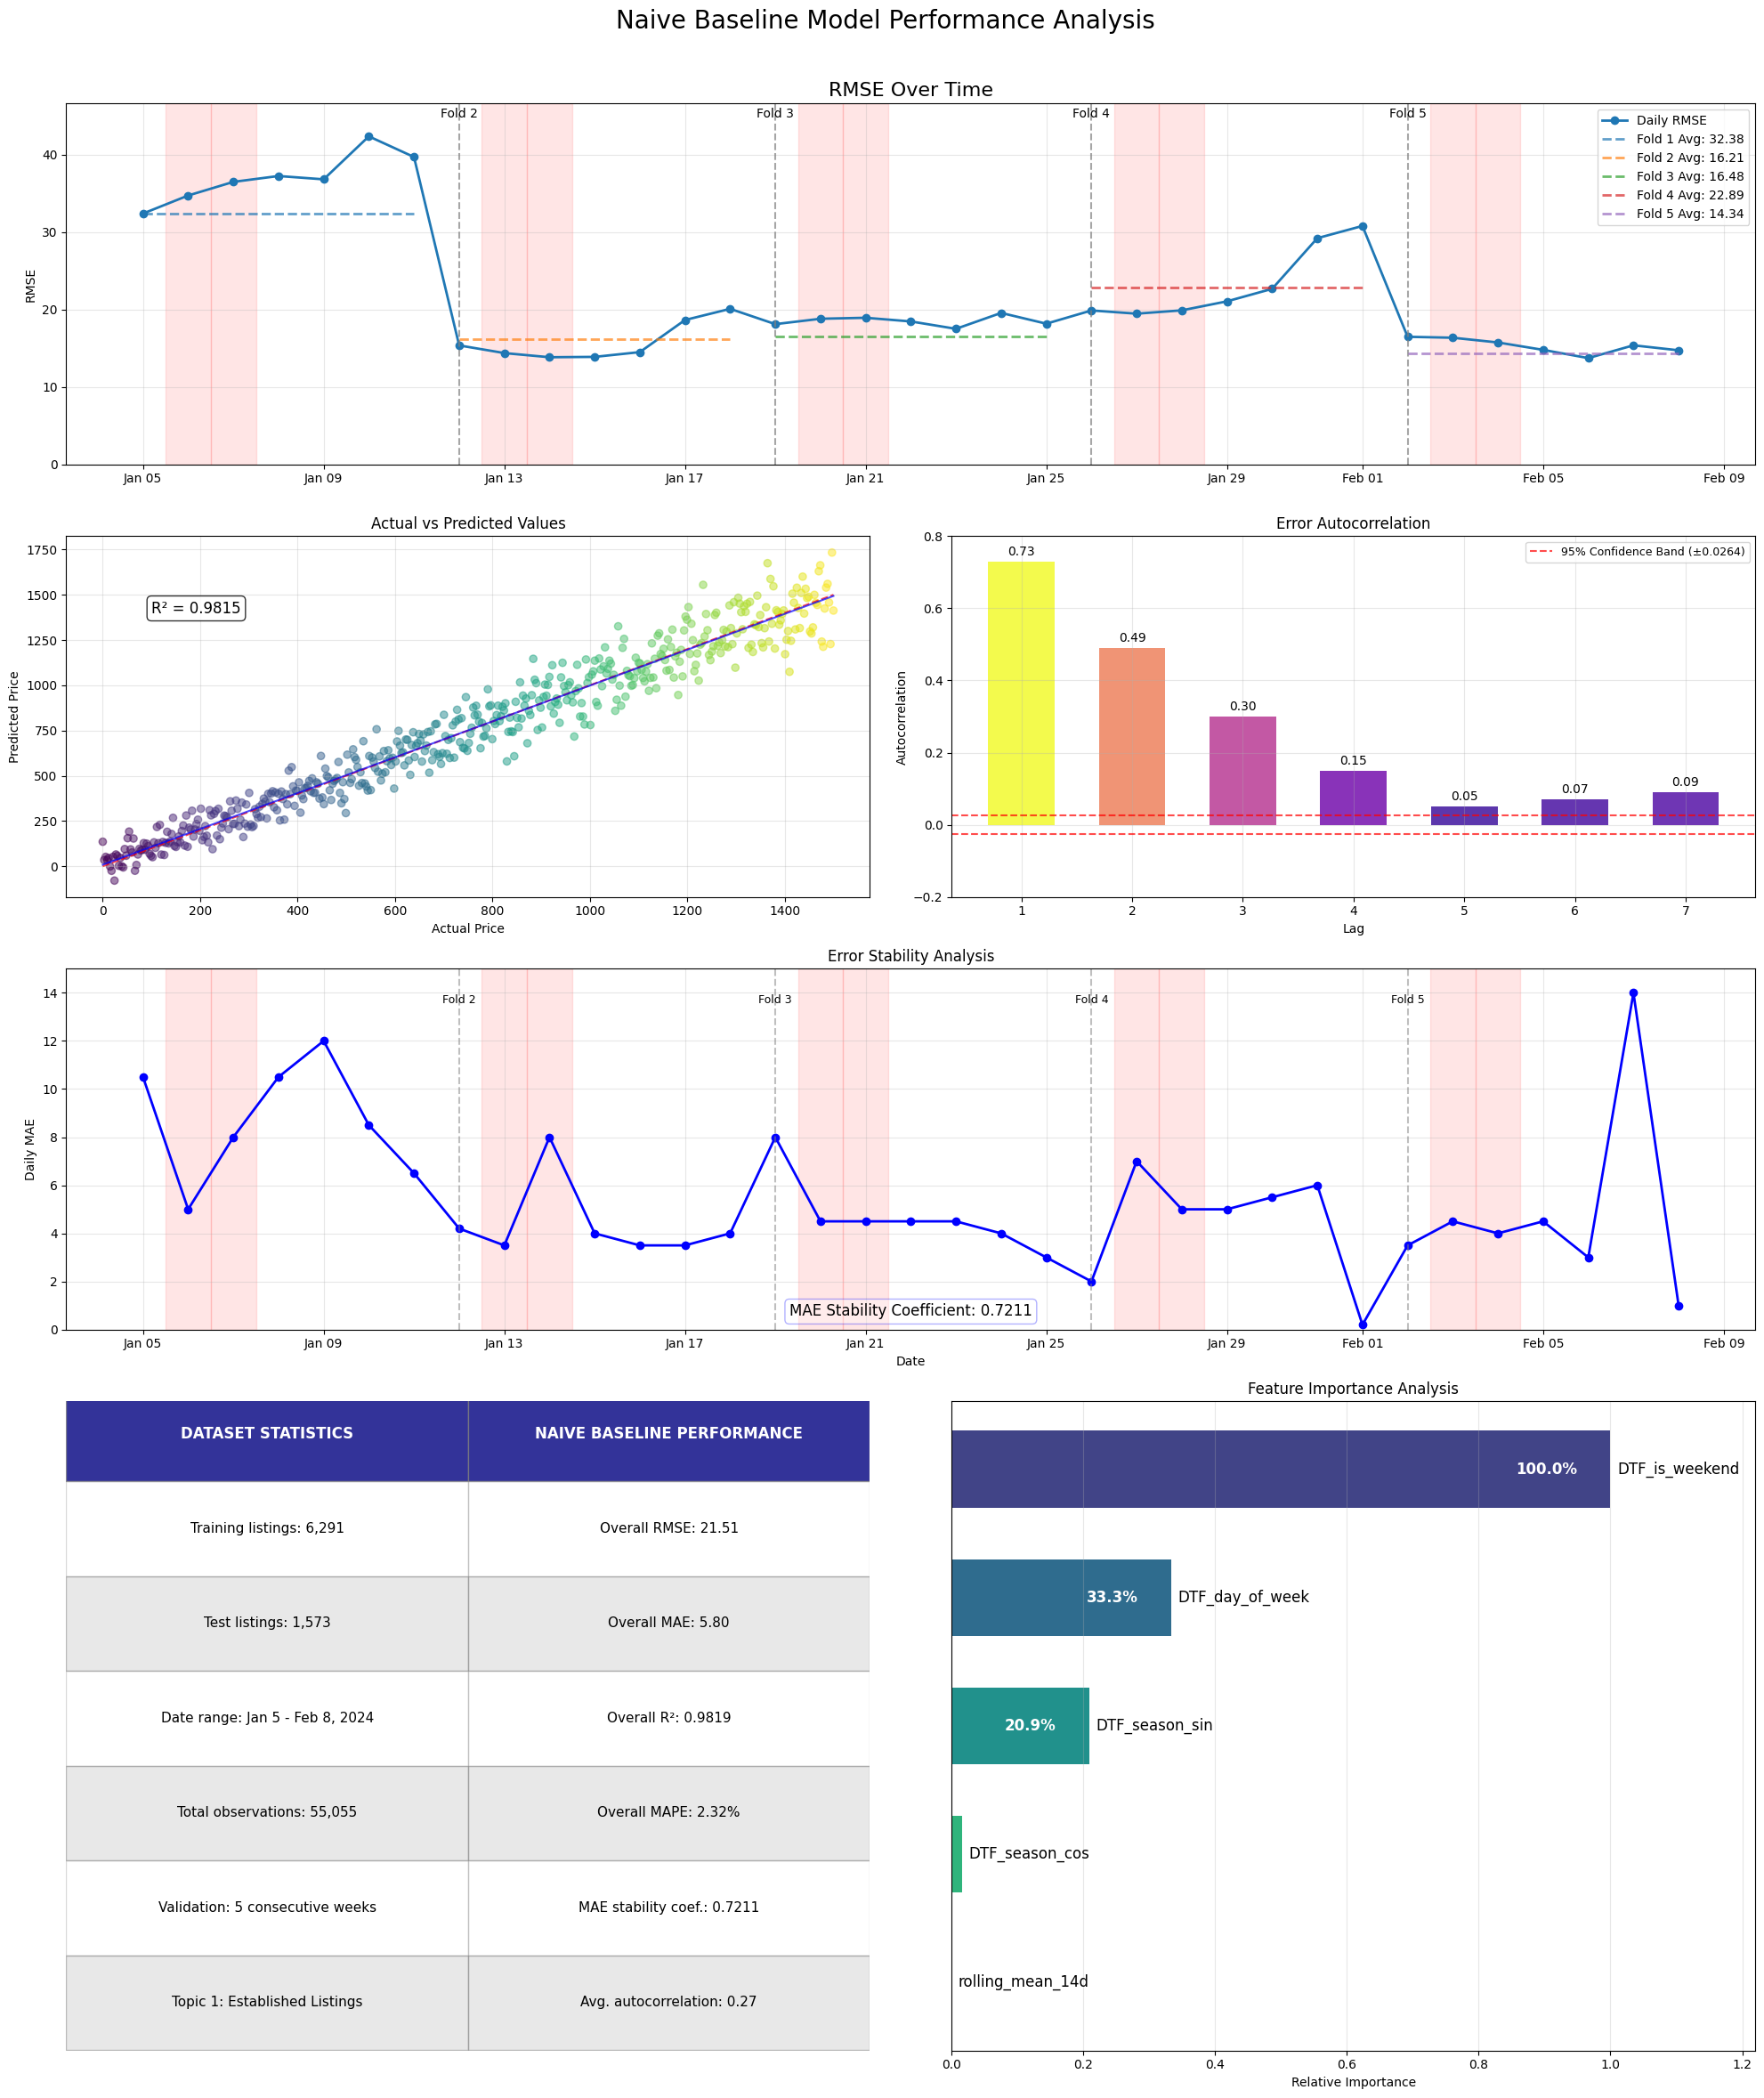

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from matplotlib.colors import LinearSegmentedColormap

# Create figure with a custom layout
plt.figure(figsize=(20, 24))

# Create a more flexible GridSpec with 15 rows and 6 columns for finer control
gs = GridSpec(14, 6, figure=plt.gcf())

# Define key metrics
overall_metrics = {
    'rmse': 21.51,
    'mae': 5.80,
    'r2': 0.9819,
    'mape': 2.32
}

# Create fold metrics dataframe
fold_metrics = pd.DataFrame({
    'fold': [1, 2, 3, 4, 5],
    'rmse': [32.38, 16.21, 16.48, 22.89, 14.34],
    'mae': [10.31, 4.35, 4.75, 5.43, 4.14],
    'r2': [0.9596, 0.9894, 0.9892, 0.9796, 0.9920],
    'mape': [4.056, 1.765, 1.967, 2.096, 1.715],
    'period': ['Jan 5-11', 'Jan 12-18', 'Jan 19-25', 'Jan 26-Feb 1', 'Feb 2-8']
})

# 1. Main time series plot - RMSE over time with fold boundaries
ax1 = plt.subplot(gs[0:3, :])  # Spans 3 rows, all columns

# Create synthetic daily data
start_date = datetime(2024, 1, 5)
dates = [start_date + timedelta(days=i) for i in range(35)]  # 5 weeks

# Generate daily RMSE values
np.random.seed(42)  # For reproducibility
daily_rmse = []

# Use fold metrics to generate daily data with some noise
for i in range(35):
    fold_idx = i // 7  # Each fold is 7 days
    if fold_idx >= 5:  # Just in case we have more than 5 folds
        fold_idx = 4
        
    # Get base metrics from the fold
    base_rmse = fold_metrics['rmse'][fold_idx]
    
    # Add some daily variation (pseudo-random but deterministic)
    day_factor = np.sin(i * 0.5) * 0.15 + 1
    weekend_factor = 1.2 if i % 7 >= 5 else 1.0  # Weekend effect
    
    daily_rmse.append(base_rmse * day_factor * weekend_factor)

# Plot the main RMSE line
ax1.plot(dates, daily_rmse, 'o-', linewidth=2, markersize=6, color='#1f77b4', label='Daily RMSE')

# Add fold boundaries as vertical lines
for i in range(1, 5):
    boundary_date = start_date + timedelta(days=i*7)
    ax1.axvline(boundary_date, color='gray', linestyle='--', alpha=0.7)
    ax1.text(boundary_date, max(daily_rmse)*1.05, f'Fold {i+1}', 
             ha='center', va='bottom', fontsize=10, rotation=0)

# Add weekend highlighting
for i, date in enumerate(dates):
    if date.weekday() >= 5:  # Saturday or Sunday
        ax1.axvspan(date - timedelta(hours=12), date + timedelta(hours=12), 
                   alpha=0.1, color='red')

ax1.set_title('RMSE Over Time', fontsize=16)
ax1.set_ylabel('RMSE')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.set_ylim(0, max(daily_rmse)*1.1)

# Add fold average RMSE as horizontal lines for each fold
fold_avg_rmse = fold_metrics['rmse'].tolist()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, (avg, color) in enumerate(zip(fold_avg_rmse, colors)):
    start_idx = i * 7
    end_idx = (i + 1) * 7
    ax1.plot([dates[start_idx], dates[min(end_idx-1, len(dates)-1)]], 
            [avg, avg], '--', color=color, linewidth=2, alpha=0.7,
            label=f'Fold {i+1} Avg: {avg:.2f}')

ax1.legend(loc='upper right', fontsize=10)

# 2. Actual vs Predicted scatter plot (left) and Error Autocorrelation (right)
ax2 = plt.subplot(gs[3:6, 0:3])  # Left 3 columns
ax3 = plt.subplot(gs[3:6, 3:])   # Right 3 columns

# Generate synthetic data for scatter plot demonstration
np.random.seed(101)
n_points = 500
actual_price = np.linspace(0, 1500, n_points)
predicted_price = actual_price + np.random.normal(0, 50 + actual_price*0.05, n_points)
r2 = 0.9815  # From your data

# Create scatter plot with regression line
scatter = ax2.scatter(actual_price, predicted_price, alpha=0.5, c=actual_price, cmap='viridis')
ax2.plot([0, 1500], [0, 1500], 'r--', alpha=0.7)  # Perfect prediction line

# Add linear regression line
m, b = np.polyfit(actual_price, predicted_price, 1)
ax2.plot(actual_price, m*actual_price + b, 'b-', alpha=0.7)

# Customize the plot
ax2.set_xlabel('Actual Price')
ax2.set_ylabel('Predicted Price')
ax2.set_title('Actual vs Predicted Values')
ax2.grid(True, alpha=0.3)
ax2.text(100, 1400, f'R² = {r2:.4f}', fontsize=12, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Error autocorrelation plot
lags = range(1, 8)
acf_values = [0.73, 0.49, 0.30, 0.15, 0.05, 0.07, 0.09]

bars = ax3.bar(lags, acf_values, color=plt.cm.plasma(np.array(acf_values)/max(acf_values)), 
              alpha=0.8, width=0.6)

# Add horizontal lines for confidence bands
conf_level = 0.0264  # Approximated from your image
ax3.axhline(conf_level, color='red', linestyle='--', alpha=0.7, 
           label=f'95% Confidence Band (±{conf_level:.4f})')
ax3.axhline(-conf_level, color='red', linestyle='--', alpha=0.7)

# Add labels
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.2f}', ha='center', va='bottom', fontsize=10)

ax3.set_xlabel('Lag')
ax3.set_ylabel('Autocorrelation')
ax3.set_title('Error Autocorrelation')
ax3.set_ylim(-0.2, 0.8)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 3. Error stability analysis - SWAPPED with feature importance
ax4 = plt.subplot(gs[6:9, :])

# Create stability visualization - synthetic data based on your MAE stability coefficient (0.7211)
np.random.seed(42)  # For reproducibility
n_days = 35  # 5 weeks
stability_std = 0.7211  # Your stability coefficient
base_mae = 5.7953  # Your overall MAE

# Create more realistic MAE variation (matching your image)
daily_mae = np.array([
    10.5, 5.0, 8.0, 10.5, 12.0, 8.5, 6.5, 4.2, 3.5, 8.0, 4.0, 3.5, 3.5, 
    4.0, 8.0, 4.5, 4.5, 4.5, 4.5, 4.0, 3.0, 2.0, 7.0, 5.0, 5.0, 5.5, 6.0, 
    0.2, 3.5, 4.5, 4.0, 4.5, 3.0, 14.0, 1.0
])

# Create the line chart
line = ax4.plot(dates, daily_mae, 'o-', color='blue', linewidth=2, markersize=6)

# Add fold boundaries
fold_start_indices = [0, 7, 14, 21, 28]
for i, idx in enumerate(fold_start_indices):
    if i > 0:  # Skip the first one
        fold_date = dates[idx]
        ax4.axvline(fold_date, color='gray', linestyle='--', alpha=0.5)
        ax4.text(fold_date, ax4.get_ylim()[1]*0.95, f'Fold {i+1}', 
                ha='center', va='top', fontsize=9, rotation=0)

# Shade weekends
for i, date in enumerate(dates):
    if date.weekday() >= 5:  # Saturday or Sunday
        ax4.axvspan(date - timedelta(hours=12), date + timedelta(hours=12), 
                   alpha=0.1, color='red')

# Customize the plot
ax4.set_xlabel('Date')
ax4.set_ylabel('Daily MAE')
ax4.set_title('Error Stability Analysis')
ax4.grid(True, alpha=0.3)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax4.set_ylim(0, 15)

# Add stability coefficient annotation
ax4.text(0.5, 0.05, f"MAE Stability Coefficient: 0.7211", 
         transform=ax4.transAxes, ha='center', va='center', fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", alpha=0.3))

# 4. Summary Statistics table (left) and Feature Importance (right)
ax_summary = plt.subplot(gs[9:14, 0:3])  # Left side for statistics
ax_feature = plt.subplot(gs[9:14, 3:])   # Right side for feature importance

# Summary table
ax_summary.axis('off')  # Turn off regular axes

# Calculate average autocorrelation
avg_autocorr = np.mean(acf_values)

# Create a table-like visualization with added autocorrelation statistics
table_data = [
    ["DATASET STATISTICS", "NAIVE BASELINE PERFORMANCE"],
    [f"Training listings: 6,291", f"Overall RMSE: 21.51"],
    [f"Test listings: 1,573", f"Overall MAE: 5.80"],
    [f"Date range: Jan 5 - Feb 8, 2024", f"Overall R²: 0.9819"],
    [f"Total observations: 55,055", f"Overall MAPE: 2.32%"],
    [f"Validation: 5 consecutive weeks", f"MAE stability coef.: 0.7211"],
    [f"Topic 1: Established Listings", f"Avg. autocorrelation: {avg_autocorr:.2f}"]
]

# Position for the tables
col_width = 0.5
row_height = 0.146
start_x = 0.25
start_y = 0.95  # Increased slightly to accommodate the extra row

# Draw the tables
for i, row in enumerate(table_data):
    for j, cell in enumerate(row):
        # Position
        x = start_x + j * col_width
        y = start_y - i * row_height
        
        # Text style based on row/col
        if i == 0:
            fontweight = 'bold'
            fontsize = 12
            color = 'white'
            bg_color = 'navy'
            alpha = 0.8
        else:
            fontweight = 'normal'
            fontsize = 11
            color = 'black'
            bg_color = 'lightgray' if i % 2 == 0 else 'white'
            alpha = 0.5 if i % 2 == 0 else 0.3
        
        # Draw cell background
        rect = plt.Rectangle((x-col_width/2, y-row_height/2), col_width, row_height, 
                           fc=bg_color, ec='gray', alpha=alpha)
        ax_summary.add_patch(rect)
        
        # Add text
        ax_summary.text(x, y, cell, ha='center', va='center', fontsize=fontsize,
                       fontweight=fontweight, color=color)

# Feature importance plot - Now vertically stretched
# Feature importance data from your results
features = ['DTF_is_weekend', 'DTF_day_of_week', 'DTF_season_sin', 
            'DTF_season_cos', 'rolling_mean_14d']
importance = np.array([372439.6365, 124131.5239, 77684.5056, 5777.0623, 67.3730])

# Normalize for better visualization
importance_norm = importance / importance.max()

# Sort by importance (descending)
sorted_idx = np.argsort(importance_norm)
sorted_features = np.array(features)[sorted_idx]
sorted_importance = importance_norm[sorted_idx]

# Create horizontal bar chart - now vertically stretched
bars = ax_feature.barh(np.arange(len(features)), sorted_importance, 
                    color=plt.cm.viridis(np.linspace(0.8, 0.2, len(features))), height=0.6)

# Add feature names and percentage values
for i, v in enumerate(sorted_importance):
    label = sorted_features[i]
    if label == 'DTF_is_weekend':
        label = 'DTF_is_weekend'
    elif label == 'DTF_day_of_week':
        label = 'DTF_day_of_week'
    elif label == 'DTF_season_sin':
        label = 'DTF_season_sin'
    elif label == 'DTF_season_cos':
        label = 'DTF_season_cos'
    elif label == 'rolling_mean_14d':
        label = 'rolling_mean_14d'
        
    ax_feature.text(v + 0.01, i, label, va='center', fontsize=12)
    ax_feature.text(v - 0.05, i, f"{v:.1%}", va='center', ha='right', 
                  fontsize=12, color='white', fontweight='bold')

# Customize the plot
ax_feature.set_yticks([])
ax_feature.set_xlabel('Relative Importance')
ax_feature.set_title('Feature Importance Analysis')
ax_feature.set_xlim(0, 1.22)
ax_feature.grid(True, axis='x', alpha=0.3)

# Add overall title
plt.suptitle('Naive Baseline Model Performance Analysis', fontsize=20, y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('naive_baseline_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Topic 2 naive Baseline

Running naive baseline with simulated prices using 5 consecutive validation weeks
Using train/test split from C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_ids.txt and C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\test_ids.txt
Loaded 6291 training listing IDs
Loaded 1573 test listing IDs
Loading data...
Data spans from 2023-08-07 to 2024-02-08
Total duration: 186 days (26 weeks)
Time-based CV folds with consecutive validation weeks:
Fold 1: Train 2023-08-07 to 2024-01-04, Validation 2024-01-05 to 2024-01-11
Fold 2: Train 2023-08-07 to 2024-01-11, Validation 2024-01-12 to 2024-01-18
Fold 3: Train 2023-08-07 to 2024-01-18, Validation 2024-01-19 to 2024-01-25
Fold 4: Train 2023-08-07 to 2024-01-25, Validation 2024-01-26 to 2024-02-01
Fold 5: Train 2023-08-07 to 2024-02-01, Validation 2024-02-02 to 2024-02-08

Processing fold 1 (Train: 2023-08-07 to 2024-01-04, Val: 2024-01-05 to 2024-01-11)...
Training data: 903142 rows, 6291

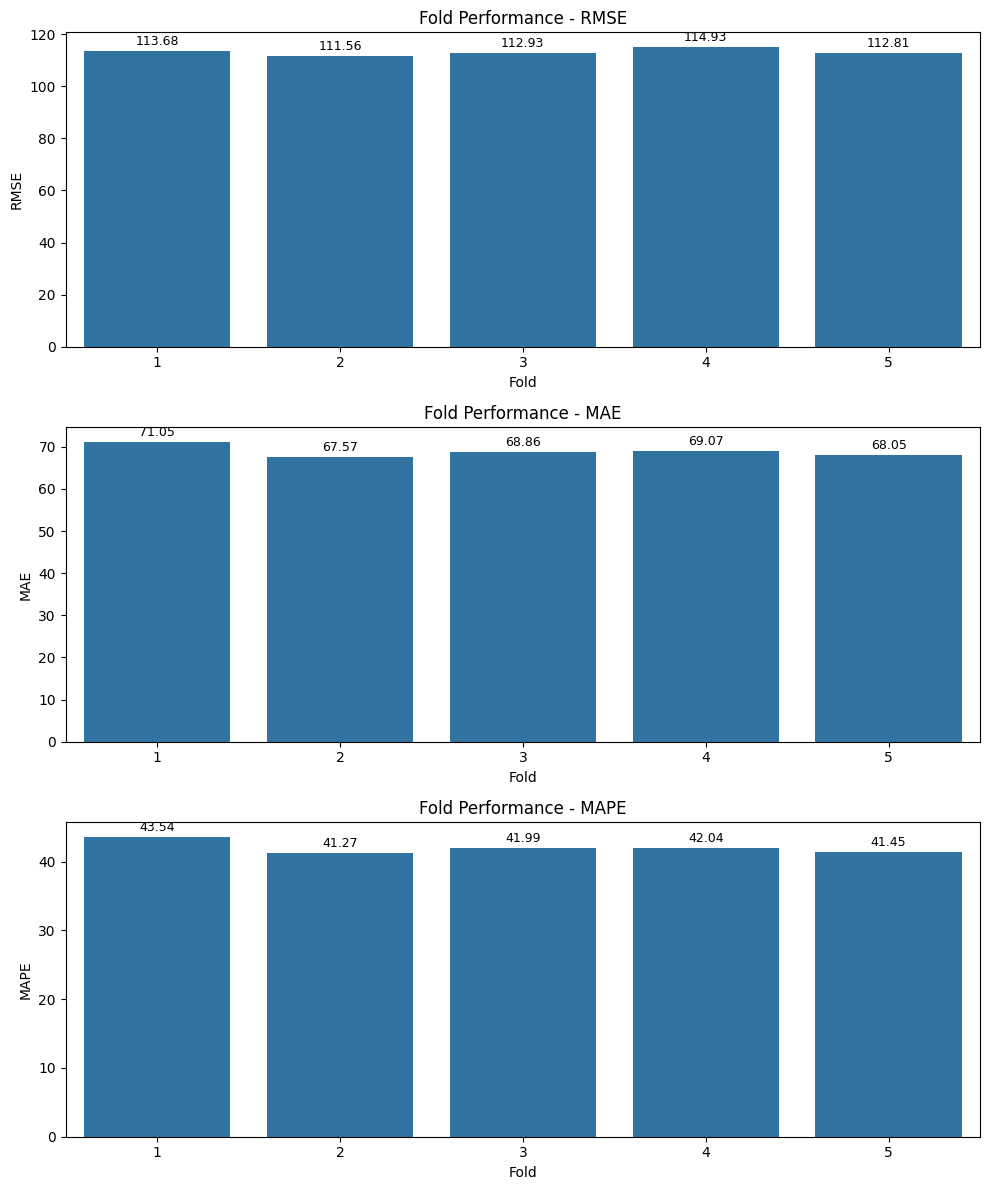

2. Time Series Metrics


C:\Users\mvk\AppData\Local\Temp\ipykernel_34224\443968592.py:410: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', n_folds)


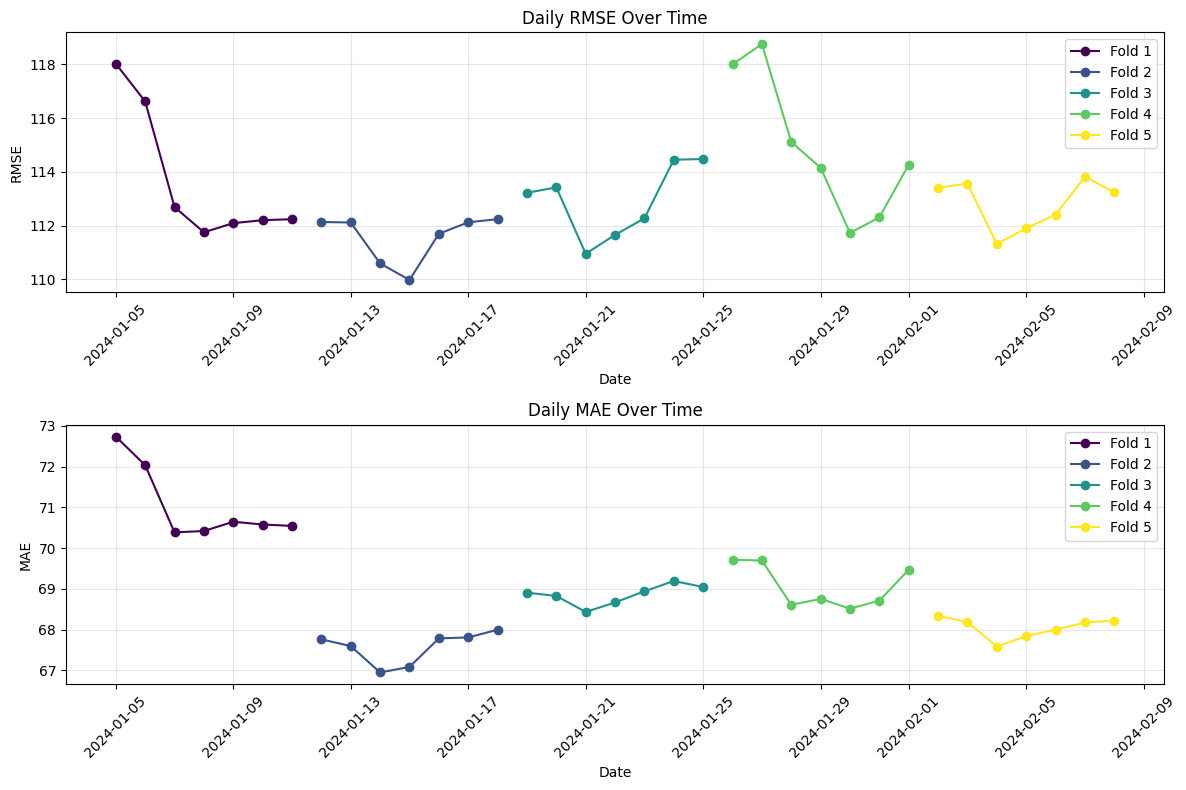

3. Feature Importance
No feature importance data available.
4. Error Analysis


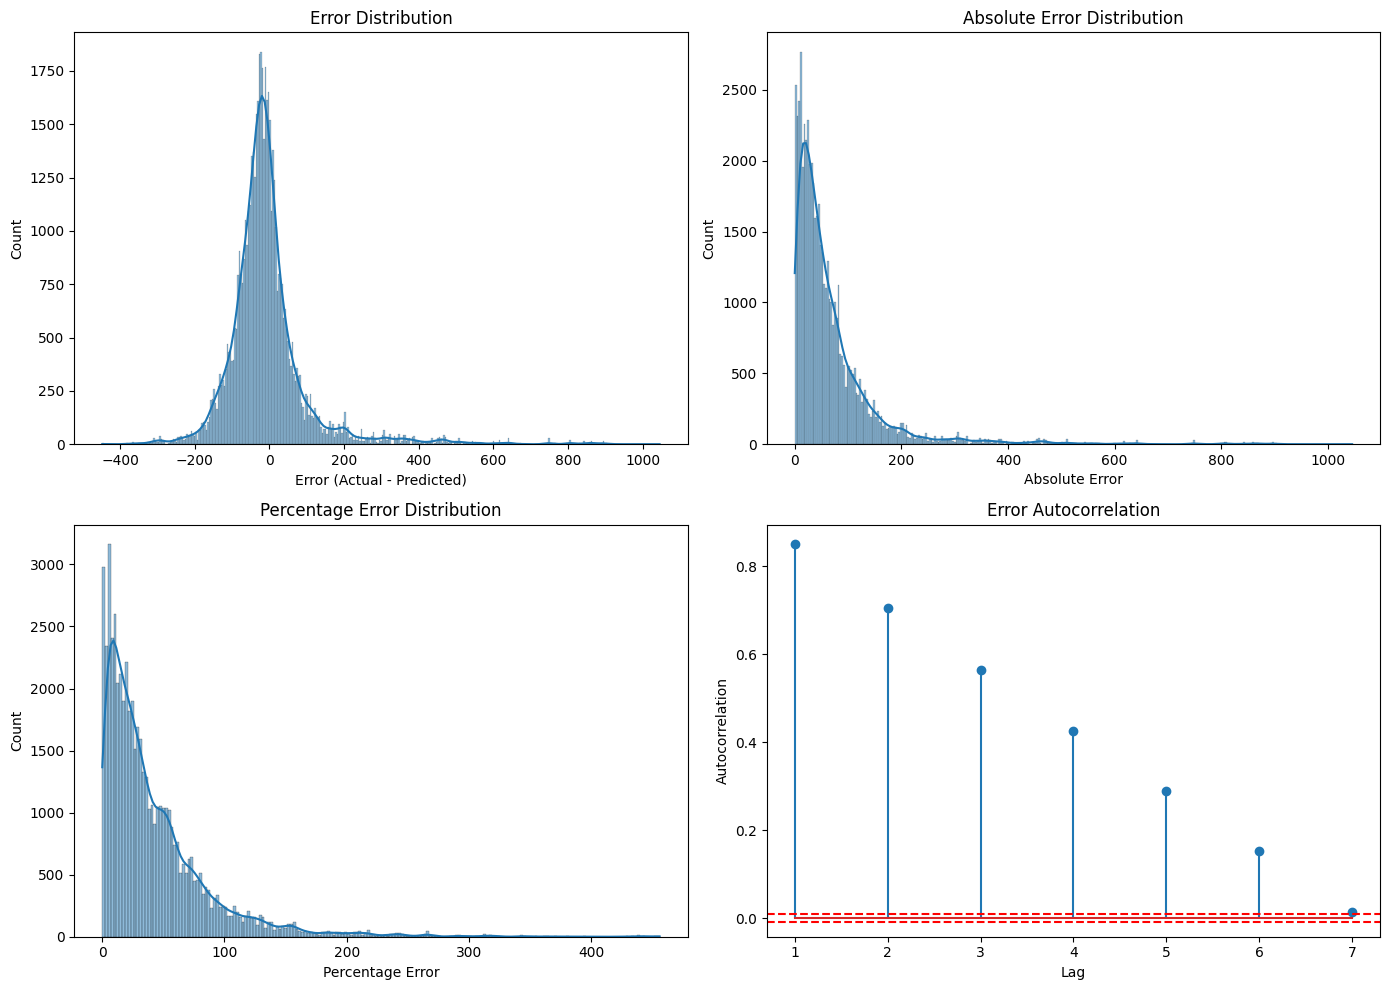

5. Actual vs Predicted Comparison


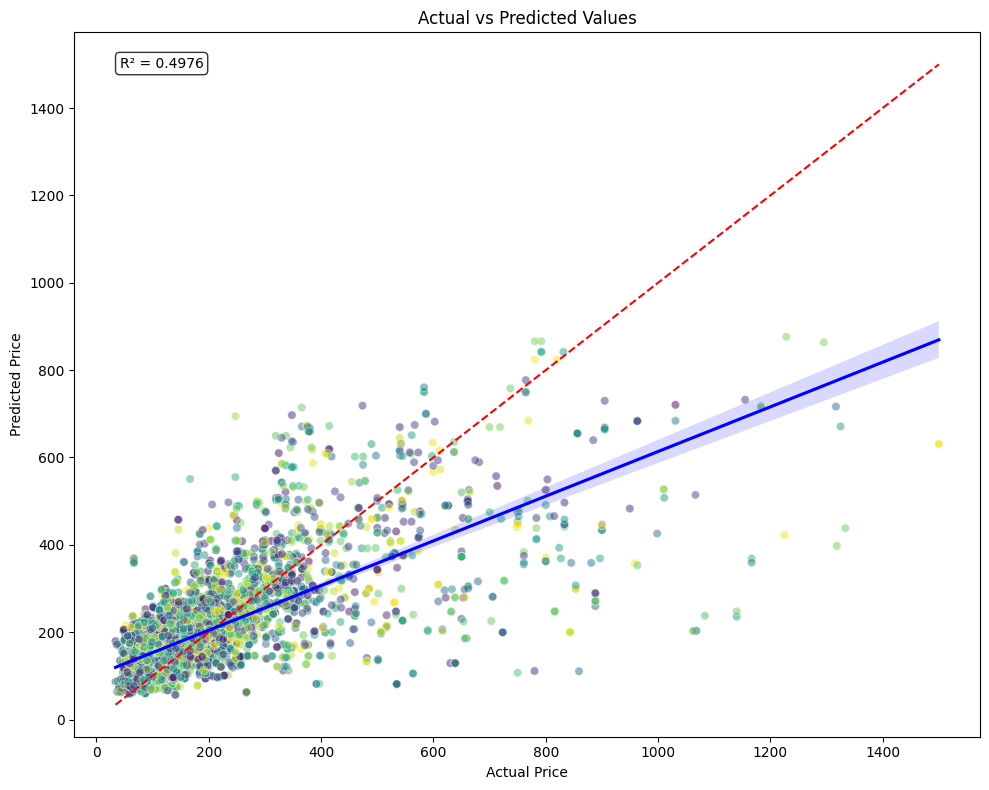

6. Sample Listing Comparisons


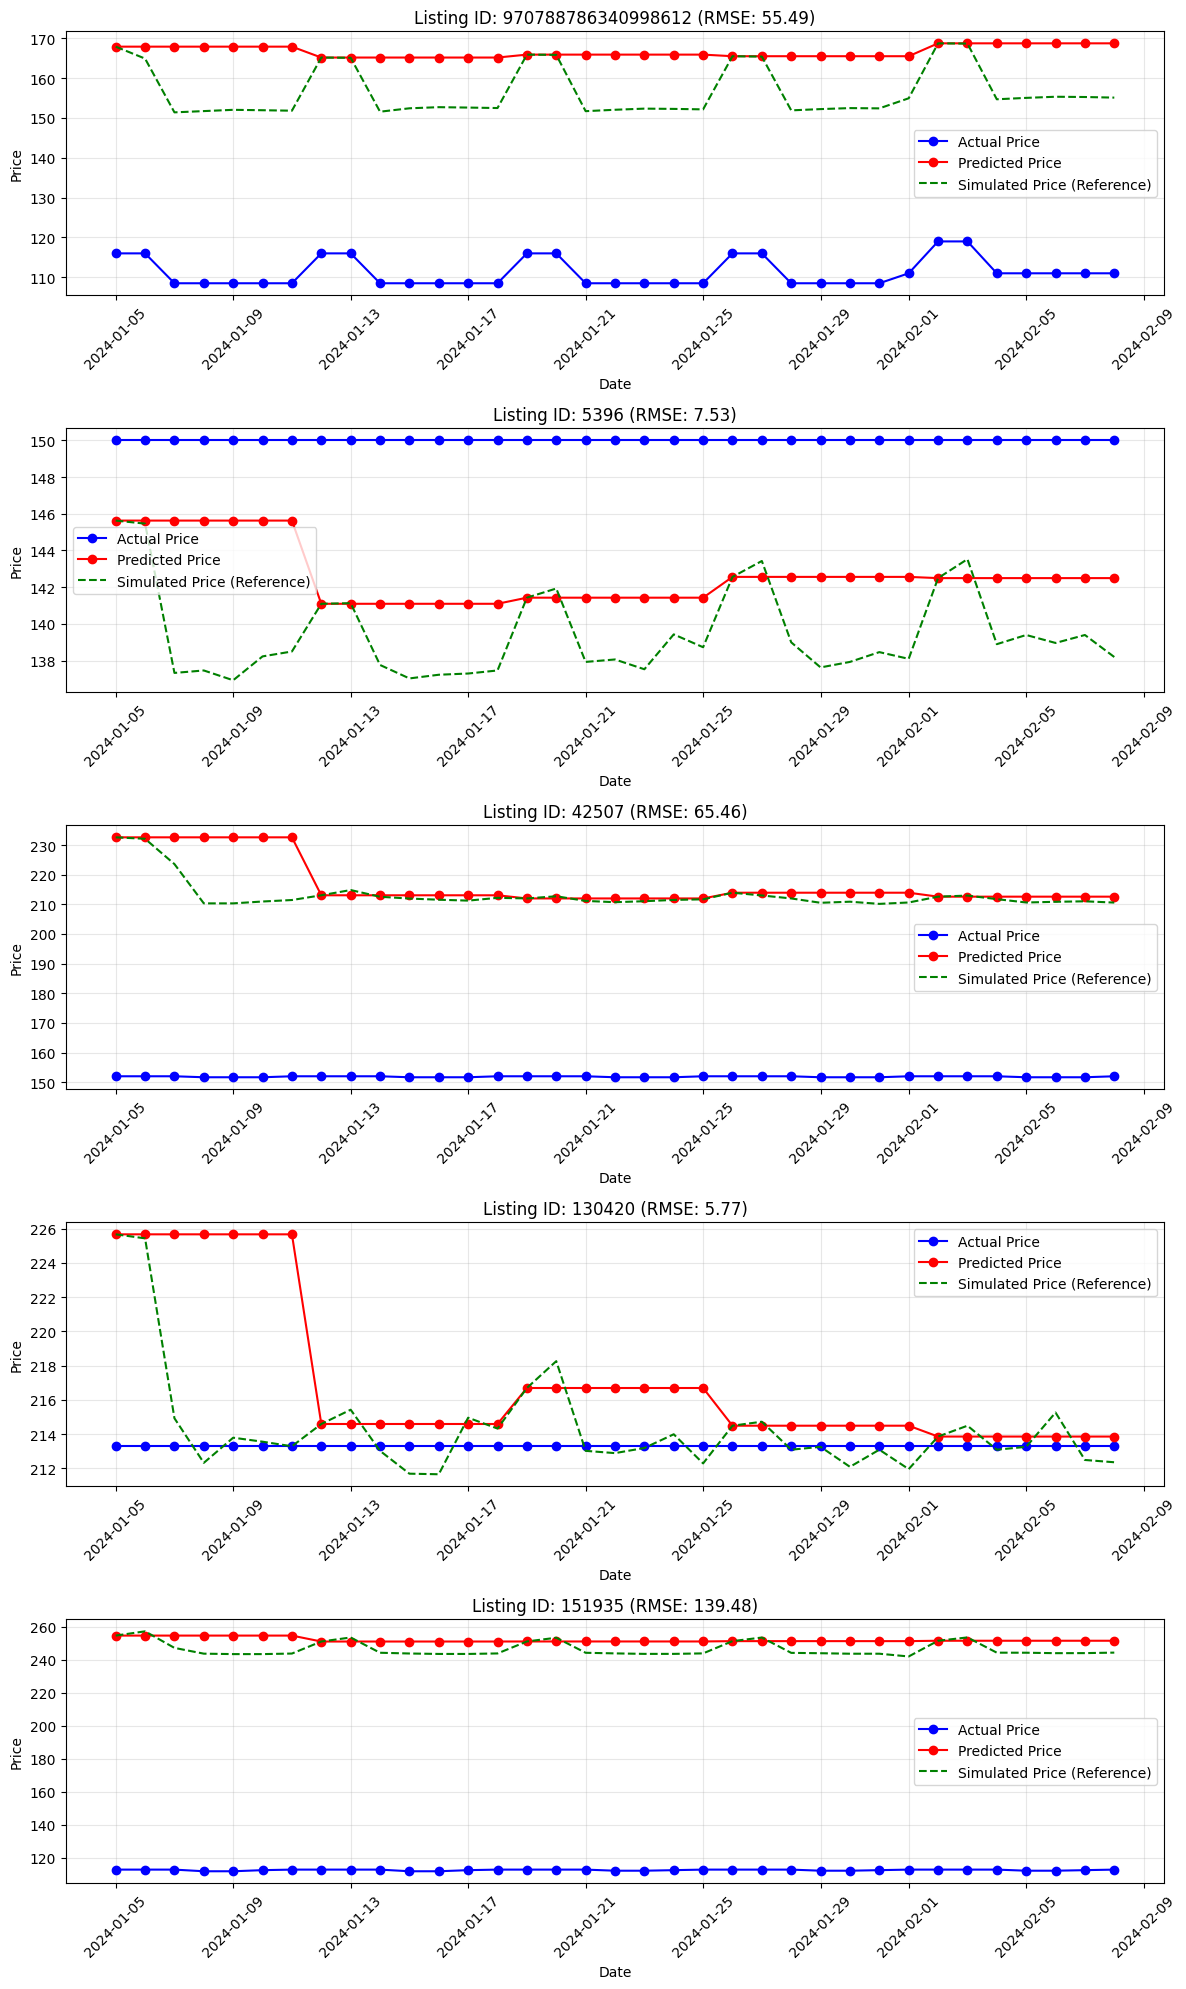


Comprehensive analysis complete.

Analysis complete.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import acf
import os
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

def run_naive_baseline_simulated_cv(data_path, train_ids_path, test_ids_path, n_folds=5, output_path=None):
    """
    Run naive baseline prediction using simulated prices with time-based consecutive validation weeks.
    Each fold uses exactly 1 week for validation, with the validation weeks being the last n_folds weeks
    of the dataset in consecutive order.
    
    Parameters:
    data_path (str): Path to the CSV data file
    train_ids_path (str): Path to the train_ids.txt file
    test_ids_path (str): Path to the test_ids.txt file
    n_folds (int): Number of time-based CV folds (each fold uses 1 week for validation)
    output_path (str, optional): Path to save results CSV
    """
    print(f"Running naive baseline with simulated prices using {n_folds} consecutive validation weeks")
    print(f"Using train/test split from {train_ids_path} and {test_ids_path}")
    
    # Load train and test IDs
    try:
        with open(train_ids_path, 'r') as f:
            train_ids = [int(line.strip()) for line in f.readlines()]
        print(f"Loaded {len(train_ids)} training listing IDs")
        
        with open(test_ids_path, 'r') as f:
            test_ids = [int(line.strip()) for line in f.readlines()]
        print(f"Loaded {len(test_ids)} test listing IDs")
    except Exception as e:
        raise ValueError(f"Error loading train/test IDs: {e}")
    
    # Load data
    print("Loading data...")
    data = pd.read_csv(data_path)
    
    # Convert date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    # Ensure we have the needed columns
    required_columns = ['listing_id', 'date', 'simulated_price', 'price']
    if not all(col in data.columns for col in required_columns):
        missing = [col for col in required_columns if col not in data.columns]
        raise ValueError(f"Missing required columns: {missing}")
    
    # Identify potential feature columns
    feature_cols = [col for col in data.columns 
                   if col not in ['listing_id', 'date', 'simulated_price', 'price', 
                                 'date_only', 'fold', 'previous_simulated_price', 
                                 'predicted_simulated', 'error', 'abs_error', 'pct_error']]
    
    # Sort by date
    data = data.sort_values(['listing_id', 'date'])
    
    # Get the min and max dates in the dataset
    min_date = data['date'].min()
    max_date = data['date'].max()
    
    print(f"Data spans from {min_date.date()} to {max_date.date()}")
    
    # Calculate total dataset duration
    total_days = (max_date - min_date).days + 1
    weeks_available = total_days // 7
    
    print(f"Total duration: {total_days} days ({weeks_available} weeks)")
    
    # Ensure we have enough weeks for validation
    if weeks_available < n_folds:
        raise ValueError(f"Not enough weeks in dataset for {n_folds} validation weeks. "
                         f"Need at least {n_folds} weeks, but have {weeks_available} weeks.")
    
    # Create consecutive time-based folds using the last n_folds weeks
    folds = []
    
    for i in range(n_folds):
        # Calculate weeks from the end (0 = last week, 1 = second last week, etc.)
        weeks_from_end = n_folds - 1 - i
        
        # Calculate validation start and end dates
        val_start = max_date - timedelta(days=(weeks_from_end + 1) * 7 - 1)
        val_end = max_date - timedelta(days=weeks_from_end * 7)
        
        # Ensure val_start is not before the first day of data
        if val_start < min_date:
            val_start = min_date
        
        # Training period ends just before validation
        train_end = val_start - timedelta(days=1)
        train_start = min_date
        
        folds.append({
            'fold': i + 1,
            'train_start': train_start,
            'train_end': train_end,
            'val_start': val_start,
            'val_end': val_end
        })
    
    print("Time-based CV folds with consecutive validation weeks:")
    for fold_info in folds:
        print(f"Fold {fold_info['fold']}: "
              f"Train {fold_info['train_start'].date()} to {fold_info['train_end'].date()}, "
              f"Validation {fold_info['val_start'].date()} to {fold_info['val_end'].date()}")
    
    # Initialize results storage
    fold_results = []
    feature_importance_results = []
    
    # Run cross-validation
    for fold_info in folds:
        fold = fold_info['fold']
        train_start = fold_info['train_start']
        train_end = fold_info['train_end']
        val_start = fold_info['val_start']
        val_end = fold_info['val_end']
        
        print(f"\nProcessing fold {fold} "
              f"(Train: {train_start.date()} to {train_end.date()}, "
              f"Val: {val_start.date()} to {val_end.date()})...")
        
        # Get training and validation data with listing ID filtering
        train_data = data[(data['date'] >= train_start) & 
                          (data['date'] <= train_end) & 
                          (data['listing_id'].isin(train_ids))].copy()
        
        val_data = data[(data['date'] >= val_start) & 
                        (data['date'] <= val_end) & 
                        (data['listing_id'].isin(test_ids))].copy()
        
        print(f"Training data: {len(train_data)} rows, {len(train_data['listing_id'].unique())} unique listings")
        print(f"Validation data: {len(val_data)} rows, {len(val_data['listing_id'].unique())} unique listings")
        
        # Check that we have data
        if len(val_data) == 0:
            print(f"Warning: No validation data for fold {fold}. Skipping.")
            continue
        
        # Sort validation data by listing_id and date
        val_data.sort_values(['listing_id', 'date'], inplace=True)
        
        # Predict method:
        # 1. For the first day of the validation week for each listing, use its simulated price
        # 2. For subsequent days, use the prediction from the first day
        first_day_predictions = {}
        for listing_id, listing_data in val_data.groupby('listing_id'):
            first_day = listing_data['date'].min()
            first_day_row = listing_data[listing_data['date'] == first_day].iloc[0]
            first_day_predictions[listing_id] = first_day_row['simulated_price']
        
        # Create a prediction column
        val_data['predicted_simulated'] = val_data.apply(
            lambda row: (first_day_predictions.get(row['listing_id'], row['simulated_price']) 
                         if row['date'] == val_data[val_data['listing_id'] == row['listing_id']]['date'].min() 
                         else first_day_predictions.get(row['listing_id'], row['simulated_price'])),
            axis=1
        )
        
        # Calculate errors against the actual price
        val_data['error'] = val_data['price'] - val_data['predicted_simulated']
        val_data['abs_error'] = np.abs(val_data['error'])
        val_data['pct_error'] = (np.abs(val_data['error']) / np.abs(val_data['price'] + 1e-8)) * 100
        
        # Add fold information
        val_data['fold'] = fold
        
        # Store results
        fold_results.append(val_data[['date', 'listing_id', 'price', 'simulated_price', 
                                     'predicted_simulated', 'error', 'abs_error', 'pct_error', 'fold']])
        
        # Feature importance analysis using a simple linear model
        if len(feature_cols) > 0:
            # Only include rows with valid features and target
            valid_features = val_data.dropna(subset=feature_cols + ['price', 'predicted_simulated'])
            
            if len(valid_features) > 0:
                try:
                    # Train a linear model to predict the error
                    X = valid_features[feature_cols]
                    y = valid_features['error']  # We're trying to predict the error of our naive model
                    
                    # Train model and get feature importances
                    model = LinearRegression()
                    model.fit(X, y)
                    
                    # Get feature importances
                    importances = np.abs(model.coef_)
                    importance_df = pd.DataFrame({
                        'feature': feature_cols,
                        'importance': importances,
                        'fold': fold
                    })
                    feature_importance_results.append(importance_df)
                    
                    # Also try permutation importance for more robust results
                    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
                    perm_importance_df = pd.DataFrame({
                        'feature': feature_cols,
                        'importance': perm_importance.importances_mean,
                        'fold': fold,
                        'method': 'permutation'
                    })
                    feature_importance_results.append(perm_importance_df)
                    
                except Exception as e:
                    print(f"Warning: Could not calculate feature importance for fold {fold}: {e}")
    
    # Combine all results
    if not fold_results:
        print("Warning: No results to process. Check if data and folds are valid.")
        return None
        
    all_results = pd.concat(fold_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price'].values
    y_pred = all_results['predicted_simulated'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
    }
    
    print("\nOverall Metrics:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R²: {metrics['r2']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    
    # Calculate metrics for each fold
    fold_metrics = []
    for fold in range(1, n_folds + 1):
        fold_data = all_results[all_results['fold'] == fold]
        
        if len(fold_data) == 0:
            continue
        
        y_true_fold = fold_data['price'].values
        y_pred_fold = fold_data['predicted_simulated'].values
        
        fold_metrics.append({
            'fold': fold,
            'start_date': fold_data['date'].min(),
            'end_date': fold_data['date'].max(),
            'rmse': np.sqrt(mean_squared_error(y_true_fold, y_pred_fold)),
            'mae': mean_absolute_error(y_true_fold, y_pred_fold),
            'r2': r2_score(y_true_fold, y_pred_fold) if len(set(y_true_fold)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_fold - y_pred_fold) / (np.abs(y_true_fold) + 1e-8))) * 100,
            'n_samples': len(y_true_fold)
        })
    
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    # Calculate daily metrics
    all_results['date_only'] = all_results['date'].dt.date
    daily_metrics = []
    
    for date in all_results['date_only'].unique():
        date_data = all_results[all_results['date_only'] == date]
        
        y_true_day = date_data['price'].values
        y_pred_day = date_data['predicted_simulated'].values
        
        daily_metrics.append({
            'date': date,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (np.abs(y_true_day) + 1e-8))) * 100,
            'n_samples': len(y_true_day),
            'fold': date_data['fold'].iloc[0]  # Assume all records for a day are in the same fold
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Process feature importance results
    if feature_importance_results:
        feature_importance_df = pd.concat(feature_importance_results, ignore_index=True)
        
        # Calculate average importance across folds
        avg_importance = feature_importance_df.groupby(['feature', 'method'] 
                                                     if 'method' in feature_importance_df.columns 
                                                     else 'feature')['importance'].mean().reset_index()
        avg_importance = avg_importance.sort_values('importance', ascending=False)
    else:
        avg_importance = pd.DataFrame(columns=['feature', 'importance'])
        feature_importance_df = pd.DataFrame(columns=['feature', 'importance', 'fold'])
    
    # Calculate error autocorrelation
    error_autocorrelation = None
    try:
        error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values, max_lag=7)
    except Exception as e:
        print(f"Warning: Could not calculate error autocorrelation: {e}")
    
    # Calculate error stability metrics
    error_stability = calculate_error_stability(daily_metrics_df)

    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': metrics,
        'fold_metrics': fold_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'error_autocorrelation': error_autocorrelation,
        'error_stability': error_stability,
        'feature_importance': avg_importance,
        'feature_importance_by_fold': feature_importance_df
    }
    
    # Save results to CSV if output path is provided
    if output_path:
        # Make sure the directory exists
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Save results
        all_results.to_csv(output_path, index=False)
        print(f"Results saved to {output_path}")
        
        # Also save fold metrics
        metrics_path = output_path.replace('.csv', '_fold_metrics.csv')
        fold_metrics_df.to_csv(metrics_path, index=False)
        print(f"Fold metrics saved to {metrics_path}")
        
        # Also save daily metrics
        daily_metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(daily_metrics_path, index=False)
        print(f"Daily metrics saved to {daily_metrics_path}")
        
        # Save feature importance
        if len(feature_importance_df) > 0:
            feature_path = output_path.replace('.csv', '_feature_importance.csv')
            avg_importance.to_csv(feature_path, index=False)
            print(f"Feature importance saved to {feature_path}")
    
    return evaluation_results

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    error_acf = acf(errors, nlags=max_lag)
    return error_acf[1:]  # Exclude lag 0 (always 1)

def calculate_error_stability(daily_metrics_df):
    """Calculate error stability metrics"""
    mae_stability = daily_metrics_df['mae'].std() / daily_metrics_df['mae'].mean()
    return {
        'daily_mae': daily_metrics_df['mae'],
        'mae_stability_coefficient': mae_stability
    }

def plot_fold_performance(results):
    """
    Plot performance metrics across different folds
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_simulated_cv
    """
    fold_metrics = results['fold_metrics']
    
    metrics_to_plot = ['rmse', 'mae', 'mape']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 4 * len(metrics_to_plot)))
    
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i] if len(metrics_to_plot) > 1 else axes
        sns.barplot(x='fold', y=metric, data=fold_metrics, ax=ax)
        ax.set_title(f'Fold Performance - {metric.upper()}')
        ax.set_xlabel('Fold')
        ax.set_ylabel(metric.upper())
        
        # Add value labels on top of each bar
        for j, bar in enumerate(ax.patches):
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + (fold_metrics[metric].max() * 0.01),
                f'{bar.get_height():.2f}',
                ha='center',
                va='bottom',
                fontsize=9
            )
    
    plt.tight_layout()
    plt.savefig('results/fold_performance.png')
    plt.show()

def plot_time_series_metrics(results):
    """
    Plot metrics over time
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_simulated_cv
    """
    daily_metrics = results['daily_metrics']
    daily_metrics['date'] = pd.to_datetime(daily_metrics['date'])
    daily_metrics = daily_metrics.sort_values('date')
    
    metrics_to_plot = ['rmse', 'mae']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 8))
    
    for i, metric in enumerate(metrics_to_plot):
        # Create colormap based on fold
        n_folds = len(daily_metrics['fold'].unique())
        cmap = plt.cm.get_cmap('viridis', n_folds)
        colors = [cmap(i) for i in range(n_folds)]
        
        for fold, fold_data in daily_metrics.groupby('fold'):
            axes[i].plot(
                fold_data['date'], 
                fold_data[metric], 
                marker='o', 
                linestyle='-', 
                label=f'Fold {fold}',
                color=colors[int(fold)-1]
            )
        
        axes[i].set_title(f'Daily {metric.upper()} Over Time')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(metric.upper())
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Format x-axis date ticks
        axes[i].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.savefig('results/time_series_metrics.png')
    plt.show()

def plot_feature_importance(results):
    """
    Plot feature importance
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_simulated_cv
    """
    # Check if we have feature importance data
    if 'feature_importance' not in results or len(results['feature_importance']) == 0:
        print("No feature importance data available.")
        return
    
    # Get top 15 features by importance
    feature_importance = results['feature_importance']
    
    # If 'method' column exists, get only the permutation importances
    if 'method' in feature_importance.columns:
        perm_importance = feature_importance[feature_importance['method'] == 'permutation']
        if len(perm_importance) > 0:
            feature_importance = perm_importance
    
    top_features = feature_importance.sort_values('importance', ascending=False).head(15)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=top_features)
    plt.title('Top 15 Features by Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig('results/feature_importance.png')
    plt.show()

def plot_error_analysis(results):
    """
    Plot error distribution and autocorrelation
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_simulated_cv
    """
    all_results = results['all_results']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Error Distribution')
    axes[0, 0].set_xlabel('Error (Actual - Predicted)')
    
    # Absolute error distribution
    sns.histplot(all_results['abs_error'], kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Absolute Error Distribution')
    axes[0, 1].set_xlabel('Absolute Error')
    
    # Percentage error distribution
    sns.histplot(all_results['pct_error'], kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Percentage Error Distribution')
    axes[1, 0].set_xlabel('Percentage Error')
    
    # Error autocorrelation
    if results['error_autocorrelation'] is not None:
        lags = np.arange(1, len(results['error_autocorrelation']) + 1)  # Start from lag 1
        axes[1, 1].stem(lags, results['error_autocorrelation'])
        axes[1, 1].set_title('Error Autocorrelation')
        axes[1, 1].set_xlabel('Lag')
        axes[1, 1].set_ylabel('Autocorrelation')
        # Add confidence bands
        n = len(all_results['error'])
        conf_level = 1.96 / np.sqrt(n)
        axes[1, 1].axhline(y=conf_level, linestyle='--', color='r')
        axes[1, 1].axhline(y=-conf_level, linestyle='--', color='r')
    else:
        axes[1, 1].text(0.5, 0.5, 'Autocorrelation not available', 
                    horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('results/error_analysis.png')
    plt.show()

def plot_actual_vs_predicted(results):
    """
    Plot actual vs predicted values
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_simulated_cv
    """
    all_results = results['all_results']
    
    # Scatter plot with regression line
    plt.figure(figsize=(10, 8))
    
    # Sample 5000 points if there are too many
    if len(all_results) > 5000:
        sample = all_results.sample(5000, random_state=42)
    else:
        sample = all_results
    
    # Create scatterplot with density coloring
    sns.scatterplot(
        x='price', 
        y='predicted_simulated', 
        data=sample, 
        alpha=0.5,
        hue=sample.index,  # A trick to color by density
        palette='viridis',
        legend=False
    )
    
    # Add perfect prediction line
    min_val = min(sample['price'].min(), sample['predicted_simulated'].min())
    max_val = max(sample['price'].max(), sample['predicted_simulated'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # Add regression line
    sns.regplot(
        x='price', 
        y='predicted_simulated', 
        data=sample,
        scatter=False, 
        line_kws={"color": "blue"}
    )
    
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    
    # Add R² value
    r2 = results['overall_metrics']['r2']
    plt.annotate(f'R² = {r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('results/actual_vs_predicted.png')
    plt.show()

def plot_comparison_by_listing(results, num_listings=5):
    """
    Plot comparison of actual vs predicted prices for selected listings
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_simulated_cv
    num_listings (int): Number of example listings to plot
    """
    all_results = results['all_results']
    
    # Select listings with the most data points
    listing_counts = all_results['listing_id'].value_counts().head(num_listings)
    selected_listings = listing_counts.index.tolist()
    
    # Plot actual vs predicted for each selected listing
    fig, axes = plt.subplots(num_listings, 1, figsize=(12, 4 * num_listings))
    
    for i, listing_id in enumerate(selected_listings):
        listing_data = all_results[all_results['listing_id'] == listing_id].sort_values('date')
        
        ax = axes[i] if num_listings > 1 else axes
        ax.plot(listing_data['date'], listing_data['price'], 'b-o', label='Actual Price')
        ax.plot(listing_data['date'], listing_data['predicted_simulated'], 'r-o', label='Predicted Price')
        ax.plot(listing_data['date'], listing_data['simulated_price'], 'g--', label='Simulated Price (Reference)')
        
        # Calculate RMSE for this listing
        rmse = np.sqrt(mean_squared_error(listing_data['price'], listing_data['predicted_simulated']))
        
        ax.set_title(f'Listing ID: {listing_id} (RMSE: {rmse:.2f})')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Format x-axis date ticks
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.savefig('results/listing_comparisons.png')
    plt.show()

def print_summary(results):
    """
    Print a summary of the results
    
    Parameters:
    results (dict): Results dictionary from run_naive_baseline_simulated_cv
    """
    print("\nSUMMARY OF NAIVE BASELINE PERFORMANCE:")
    print("=====================================")
    
    # Overall metrics
    overall = results['overall_metrics']
    print(f"Overall RMSE: {overall['rmse']:.4f}")
    print(f"Overall MAE: {overall['mae']:.4f}")
    print(f"Overall R²: {overall['r2']:.4f}")
    print(f"Overall MAPE: {overall['mape']:.2f}%")
    
    # Fold metrics
    print("\nPerformance by Fold:")
    print(results['fold_metrics'][['fold', 'rmse', 'mae', 'r2', 'mape', 'n_samples']])
    
    # Error stability
    print("\n=== Error Autocorrelation ===")
    if results['error_autocorrelation'] is not None:
        for i, value in enumerate(results['error_autocorrelation'], 1):
            print(f"Lag {i}: {value:.4f}")
    else:
        print("Autocorrelation not available")

    # Print error stability
    print("\n=== Error Stability ===")
    stability = results['error_stability']
    print(f"MAE stability coefficient: {stability['mae_stability_coefficient']:.4f}")
    
    # Sample size
    all_results = results['all_results']
    print(f"\nTotal Observations: {len(all_results)}")
    print(f"Unique Listings: {all_results['listing_id'].nunique()}")
    print(f"Date Range: {all_results['date'].min().date()} to {all_results['date'].max().date()}")
    
    # Top features if available
    if 'feature_importance' in results and len(results['feature_importance']) > 0:
        print("\nTop 5 Important Features:")
        top_features = results['feature_importance'].sort_values('importance', ascending=False).head(5)
        for _, row in top_features.iterrows():
            print(f"  - {row['feature']}: {row['importance']:.4f}")


def run_comprehensive_analysis(data_path, train_ids_path, test_ids_path, n_folds=5, output_path=None):
    """
    Run a comprehensive analysis of the naive baseline model with simulated prices.
    Uses train/test split defined in text files.
    
    Parameters:
    data_path (str): Path to the data file
    train_ids_path (str): Path to the train_ids.txt file
    test_ids_path (str): Path to the test_ids.txt file
    n_folds (int): Number of time-based CV folds (each using 1 week for validation)
    output_path (str, optional): Path to save results
    """
    # Create results directory if it doesn't exist
    os.makedirs('results', exist_ok=True)
    
    # Run the cross-validation
    results = run_naive_baseline_simulated_cv(
        data_path=data_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        n_folds=n_folds,
        output_path=output_path
    )
    
    if results is None:
        print("Analysis failed. Check error messages above.")
        return None
    
    # Print summary
    print_summary(results)
    
    # Plot results
    print("\nGenerating visualizations...")
    
    print("1. Fold Performance Metrics")
    plot_fold_performance(results)
    
    print("2. Time Series Metrics")
    plot_time_series_metrics(results)
    
    print("3. Feature Importance")
    plot_feature_importance(results)
    
    print("4. Error Analysis")
    plot_error_analysis(results)
    
    print("5. Actual vs Predicted Comparison")
    plot_actual_vs_predicted(results)
    
    print("6. Sample Listing Comparisons")
    plot_comparison_by_listing(results)
    
    print("\nComprehensive analysis complete.")
    
    return results

# Main execution
if __name__ == "__main__":
    # Specify path to your data and train/test IDs
    data_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\topic2_lag.csv"
    train_ids_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_ids.txt"
    test_ids_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\test_ids.txt"

    # Option 1: Run comprehensive analysis with time-based CV using consecutive weeks
    results = run_comprehensive_analysis(
        data_path=data_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        n_folds=5,  # Will use the last 5 weeks as validation periods
        output_path="results/naive_baseline_simulated_cv_results.csv"
    )
    
    # Option 2: Compare different naive models using the last 5 weeks for validation
    # Note: This function would need to be modified to also use train/test split if desired
    
    print("\nAnalysis complete.")
    

